# Gráficas comparar variando ventanas de tiempo

## Packages

In [208]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Carpeta para gráficas

In [209]:
n=1230
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-10-24"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days/Analysis"

# Crear subcarpeta para guardar resultados de análisis
analysis_dir = os.path.join(output_dir, "WindowsFAI")
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir}")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar graficas de análisis con multiples windows
graphics_dir = os.path.join(analysis_dir, "graphics_from_existing")     # Directorio para nuevas gráficas
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de gráficas de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de gráficas de análisis creada: {graphics_dir}")
os.makedirs(graphics_dir, exist_ok=True)

# Parámetros (ajusta según tus datos)
n_days = n  # Ajusta según tu análisis



⚠️ La carpeta de análisis ya existía: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI
⚠️ La carpeta de gráficas de análisis ya existía: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing


In [210]:
# Directorios específicos 
association_dir = os.path.join(analysis_dir, "association_analysis_65to120_step5")
if os.path.exists(association_dir):
    print(f"⚠️ La carpeta de association_dir ya existía: {association_dir}")
else:
    os.makedirs(association_dir , exist_ok=True)
    print(f"📁 Carpeta de association_dir creada: {association_dir}")
os.makedirs(association_dir, exist_ok=True)


anticipation_dir = os.path.join(analysis_dir, "anticipation_analysis_65to120_step5")
if os.path.exists(anticipation_dir):
    print(f"⚠️ La carpeta de anticipation_dir ya existía: {anticipation_dir}")
else:
    os.makedirs(anticipation_dir , exist_ok=True)
    print(f"📁 Carpeta de anticipation_dir creada: {association_dir}")

    

⚠️ La carpeta de association_dir ya existía: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/association_analysis_65to120_step5
⚠️ La carpeta de anticipation_dir ya existía: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/anticipation_analysis_65to120_step5


## Función para leer y graficar ANÁLISIS DE ASOCIACIÓN

In [211]:
def plot_fai_association_summary(df_fai_assoc, n_days, window_minutes, column="Associated_Flare"):
    """
    Genera un gráfico de barras mostrando el porcentaje de FAIs
    que están asociados con flares (True) y no asociados (False).

    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare').
    n_days : int
        Número de días analizados (para título).
    window_minutes : int
        Ventana de tiempo en minutos usada para definir asociación.
    column : str, default="Associated_Flare"
        Nombre de la columna con valores True/False.
    """
    # Usar el dataframe directamente
    df_fai = df_fai_assoc.copy()

    # Verificar que la columna existe
    if column not in df_fai.columns:
        available_columns = df_fai.columns.tolist()
        raise ValueError(f"Columna '{column}' no encontrada. Columnas disponibles: {available_columns}")

    # Contar True (asociados) vs False (no asociados)
    counts = df_fai[column].value_counts()
    total = counts.sum()

    # Reordenar para que True = Asociados aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)

    # Configuración del plot
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'], alpha=0.8)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Associated', 'Not Associated'])
    ax.set_ylabel("Percentage of FAIs (%)")
    ax.set_title(f"FAI Alerts Associated with Flares\n({n_days} days, Window = {window_minutes} min)",
                 pad=20)

    # Añadir porcentajes dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')

    # Añadir conteos absolutos arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 1,
                    f"n={int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")

    # Recuadro con total de alertas FAI dentro del gráfico
    ax.text(0.95, 0.95, f"Total FAI Alerts = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=11,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_FAI_associated_Flares_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    associated_count = counts.get(True, 0)
    not_associated_count = counts.get(False, 0)
    
    print(f"\n--- Estadísticas de Asociación FAI-Flare ---")
    print(f"Total alertas FAI analizadas: {total}")
    print(f"FAIs asociados a flares: {associated_count} ({percentages.get(True, 0):.1f}%)")
    print(f"FAIs no asociados: {not_associated_count} ({percentages.get(False, 0):.1f}%)")
    print(f"Ventana de asociación: {window_minutes} minutos")



In [212]:
def plot_fai_to_peak_times(df_fai_assoc, n_days, window_minutes, bins=20):
    """
    Muestra la distribución de tiempos desde FAI hasta el pico del flare.
    """
    # Filtrar FAIs asociados con tiempo válido
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0)
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay FAIs asociados con tiempos válidos")
        return
    
    times = df_associated['Time_to_flare'].values
    
    # Configuración
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histograma
    n, bins, patches = ax1.hist(times, bins=bins, alpha=0.7, color='steelblue', 
                               edgecolor='black', density=False)
    ax1.set_xlabel('Time from FAI to Peak (minutes)')
    ax1.set_ylabel('Number of FAIs')
    ax1.set_title(f'Distribution of FAI-to-Peak Times\n({n_days} days, Window: {window_minutes} min)')
    ax1.grid(True, alpha=0.3)
    
    # Añadir línea de media y mediana
    mean_time = np.mean(times)
    median_time = np.median(times)
    ax1.axvline(mean_time, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_time:.1f} min')
    ax1.axvline(median_time, color='orange', linestyle='--', linewidth=2,
                label=f'Median: {median_time:.1f} min')
    ax1.legend()
    
    # Boxplot
    ax2.boxplot(times, vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1),
               capprops=dict(color='black', linewidth=1))
    ax2.set_ylabel('Time from FAI to Peak (minutes)')
    ax2.set_title('Boxplot of FAI-to-Peak Times')
    ax2.set_xticks([1])
    ax2.set_xticklabels(['FAI Times'])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir puntos individuales para ver distribución
    y_jitter = np.random.normal(1, 0.04, size=len(times))
    ax2.scatter(y_jitter, times, alpha=0.4, color='blue', s=30)
    
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_to_Peak_Times_Distribution_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas
    print(f"\n=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===")
    print(f"Total FAIs asociados: {len(df_associated)}")
    print(f"Tiempo mínimo: {np.min(times):.1f} minutos")
    print(f"Tiempo máximo: {np.max(times):.1f} minutos")
    print(f"Tiempo promedio: {mean_time:.1f} minutos")
    print(f"Tiempo mediano: {median_time:.1f} minutos")
    print(f"Desviación estándar: {np.std(times):.1f} minutos")
    print(f"Percentil 25: {np.percentile(times, 25):.1f} minutos")
    print(f"Percentil 75: {np.percentile(times, 75):.1f} minutos")



In [213]:
def plot_fai_times_by_class(df_fai_assoc, n_days, window_minutes):
    """
    Muestra los tiempos FAI-to-Peak organizados por clase de flare.
    """
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0) &
        (df_fai_assoc['Flare_Class'].notna())
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay datos válidos para graficar")
        return
    
    # Ordenar clases
    class_order = ['A', 'B', 'C', 'M', 'X']
    available_classes = [cls for cls in class_order if cls in df_associated['Flare_Class'].str[0].unique()]
    
    # Preparar datos para boxplot
    data_by_class = []
    labels = []
    
    for flare_class in available_classes:
        class_times = df_associated[df_associated['Flare_Class'].str[0] == flare_class]['Time_to_flare']
        if len(class_times) > 0:
            data_by_class.append(class_times)
            labels.append(flare_class)
    
    if not data_by_class:
        print("No hay suficientes datos por clase")
        return
    
    # Gráfica
    plt.figure(figsize=(10, 6))
    
    # Boxplot por clase
    box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2),
                          whiskerprops=dict(color='black', linewidth=1))
    
    # Añadir puntos individuales con jitter
    for i, class_times in enumerate(data_by_class):
        x_jitter = np.random.normal(i+1, 0.05, size=len(class_times))
        plt.scatter(x_jitter, class_times, alpha=0.5, color='blue', s=40)
    
    plt.xlabel('Flare Class')
    plt.ylabel('Time from FAI to Peak (minutes)')
    plt.title(f'FAI-to-Peak Times by Flare Class\n({n_days} days, Window: {window_minutes} min)', pad=30)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Añadir estadísticas en el gráfico
    for i, class_times in enumerate(data_by_class):
        mean_time = np.mean(class_times)
        count = len(class_times)
        plt.text(i+1, np.max(class_times) + 2, f'n={count}\nμ={mean_time:.1f}', 
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    output_name = f"{n_days}d_FAI_Times_by_Class_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas por clase
    print(f"\n=== TIEMPOS POR CLASE DE FLARE ===")
    for i, flare_class in enumerate(labels):
        class_times = data_by_class[i]
        print(f"Clase {flare_class}:")
        print(f"  Count: {len(class_times)}")
        print(f"  Mean: {np.mean(class_times):.1f} min")
        print(f"  Median: {np.median(class_times):.1f} min")
        print(f"  Std: {np.std(class_times):.1f} min")



### corre las 3 funciones anteriores

In [214]:
def plot_existing_association_analysis(base_dir, n_days):
    """
    Lee archivos existentes de análisis de asociación y genera gráficas.
    """
    # Encontrar todos los archivos CSV en el directorio
    pattern = os.path.join(base_dir, "df_fai_assoc_*.csv")
    csv_files = glob.glob(pattern)
    
    if not csv_files:
        print(f"❌ No se encontraron archivos en: {base_dir}")
        return
    
    print(f"📁 Encontrados {len(csv_files)} archivos en: {base_dir}")
    
    # Crear directorio para gráficas de asociación
    association_graphics_dir = os.path.join(graphics_dir, "association_plots")
    os.makedirs(association_graphics_dir, exist_ok=True)
    
    for csv_file in sorted(csv_files):
        try:
            # Extraer window_minutes del nombre del archivo
            filename = os.path.basename(csv_file)
            window_minutes = int(filename.split('_')[3].replace('min.csv', ''))
            
            print(f"📊 Procesando: {filename} (ventana: {window_minutes} min)")
            
            # Leer el archivo
            df_fai_assoc = pd.read_csv(csv_file)
            
            # Convertir columnas de tiempo si es necesario
            time_columns = ['Time_FAI', 'Flare_StartTime', 'Flare_EndTime', 'Flare_PeakTime']
            for col in time_columns:
                if col in df_fai_assoc.columns:
                    df_fai_assoc[col] = pd.to_datetime(df_fai_assoc[col])
            
            # Gráfica 1: Resumen de asociación
            plot_fai_association_summary(
                df_fai_assoc=df_fai_assoc,
                n_days=n_days,
                window_minutes=window_minutes,
                column="Associated_Flare"
            )
            
            # Mover gráfica al directorio específico
            original_plot = f"{n_days}d_FAI_associated_Flares_Window{window_minutes}min.png"
            new_plot = f"association_summary_{window_minutes}min.png"
            original_path = os.path.join(graphics_dir, original_plot)
            new_path = os.path.join(association_graphics_dir, new_plot)
            
            if os.path.exists(original_path):
                os.rename(original_path, new_path)
                print(f"   ✅ Gráfica 1 guardada: {new_plot}")
            
            # Gráfica 2: Tiempos FAI-to-Peak (si hay datos asociados)
            if df_fai_assoc['Associated_Flare'].sum() > 0:
                plot_fai_to_peak_times(
                    df_fai_assoc=df_fai_assoc,
                    n_days=n_days,
                    window_minutes=window_minutes,
                    bins=15
                )
                
                # Mover gráfica de tiempos
                original_plot2 = f"{n_days}d_FAI_to_Peak_Times_Distribution_Window{window_minutes}min.png"
                new_plot2 = f"fai_to_peak_times_{window_minutes}min.png"
                original_path2 = os.path.join(graphics_dir, original_plot2)
                new_path2 = os.path.join(association_graphics_dir, new_plot2)
                
                if os.path.exists(original_path2):
                    os.rename(original_path2, new_path2)
                    print(f"   ✅ Gráfica 2 guardada: {new_plot2}")
            
            # Gráfica 3: Tiempos por clase (si hay datos)
            if df_fai_assoc['Associated_Flare'].sum() > 0 and 'Flare_Class' in df_fai_assoc.columns:
                plot_fai_times_by_class(
                    df_fai_assoc=df_fai_assoc,
                    n_days=n_days,
                    window_minutes=window_minutes
                )
                
                # Mover gráfica de clases
                original_plot3 = f"{n_days}d_FAI_Times_by_Class_Window{window_minutes}min.png"
                new_plot3 = f"fai_times_by_class_{window_minutes}min.png"
                original_path3 = os.path.join(graphics_dir, original_plot3)
                new_path3 = os.path.join(association_graphics_dir, new_plot3)
                
                if os.path.exists(original_path3):
                    os.rename(original_path3, new_path3)
                    print(f"   ✅ Gráfica 3 guardada: {new_plot3}")
                    
        except Exception as e:
            print(f"   ❌ Error procesando {csv_file}: {e}")
            continue
    
    print(f"🎯 Gráficas de asociación guardadas en: {association_graphics_dir}")
    return association_graphics_dir

📁 Encontrados 12 archivos en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/association_analysis_65to120_step5
📊 Procesando: df_fai_assoc_100min.csv (ventana: 100 min)


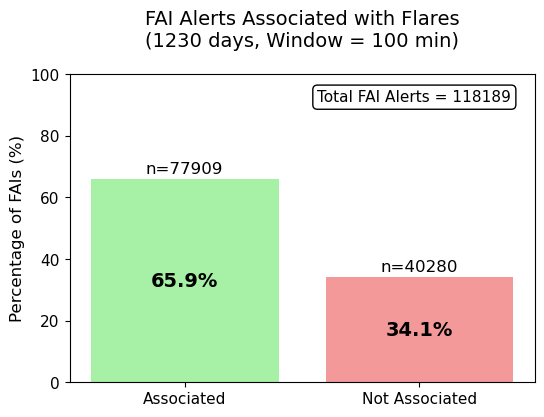

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window100min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 77909 (65.9%)
FAIs no asociados: 40280 (34.1%)
Ventana de asociación: 100 minutos
   ✅ Gráfica 1 guardada: association_summary_100min.png


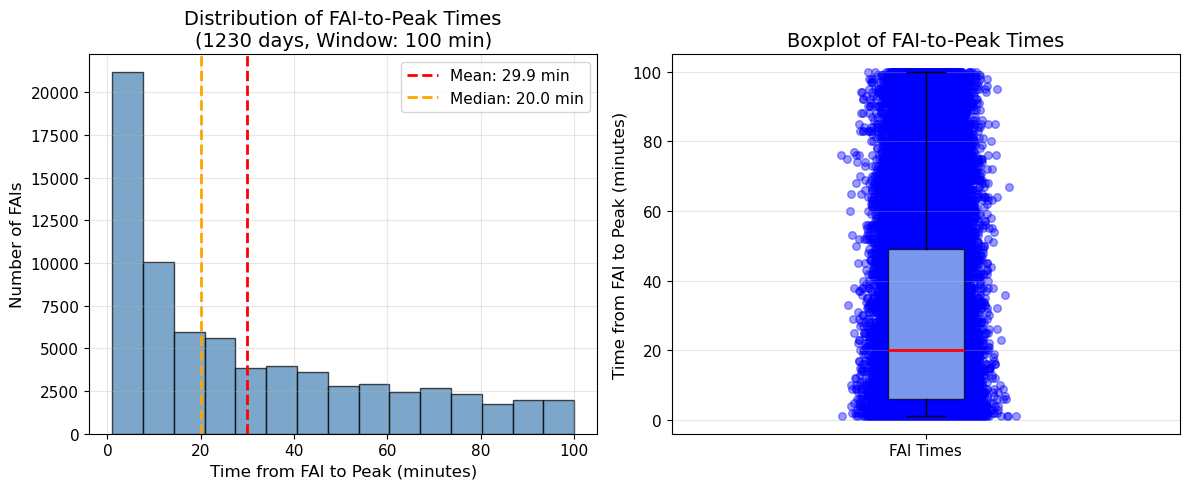

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window100min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 73046
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 100.0 minutos
Tiempo promedio: 29.9 minutos
Tiempo mediano: 20.0 minutos
Desviación estándar: 28.0 minutos
Percentil 25: 6.0 minutos
Percentil 75: 49.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_100min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


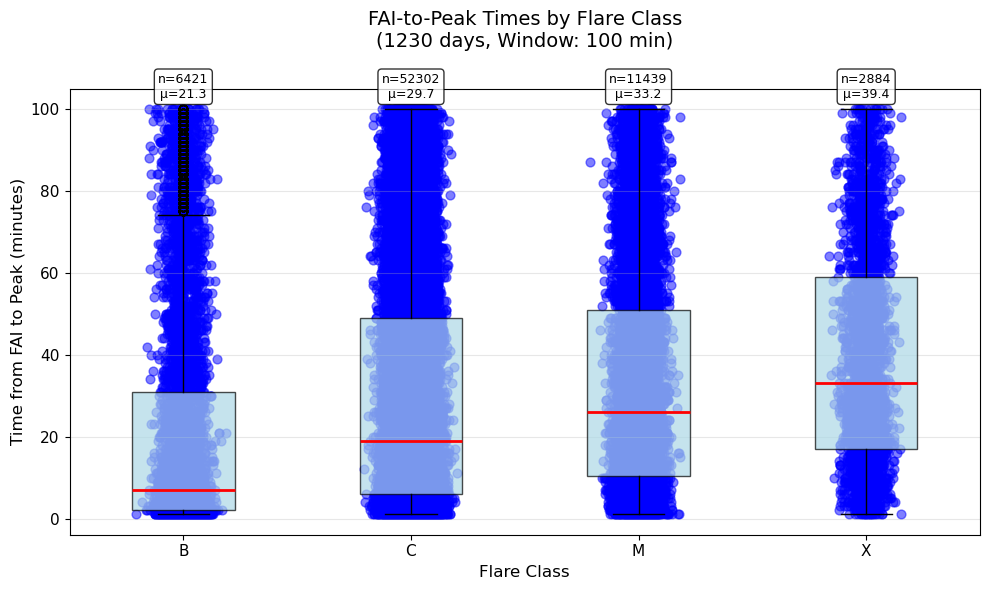

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window100min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 6421
  Mean: 21.3 min
  Median: 7.0 min
  Std: 27.7 min
Clase C:
  Count: 52302
  Mean: 29.7 min
  Median: 19.0 min
  Std: 28.1 min
Clase M:
  Count: 11439
  Mean: 33.2 min
  Median: 26.0 min
  Std: 26.6 min
Clase X:
  Count: 2884
  Mean: 39.4 min
  Median: 33.0 min
  Std: 26.4 min
   ✅ Gráfica 3 guardada: fai_times_by_class_100min.png
📊 Procesando: df_fai_assoc_105min.csv (ventana: 105 min)


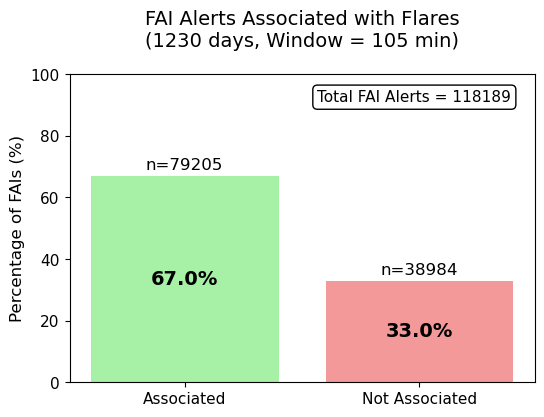

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window105min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 79205 (67.0%)
FAIs no asociados: 38984 (33.0%)
Ventana de asociación: 105 minutos
   ✅ Gráfica 1 guardada: association_summary_105min.png


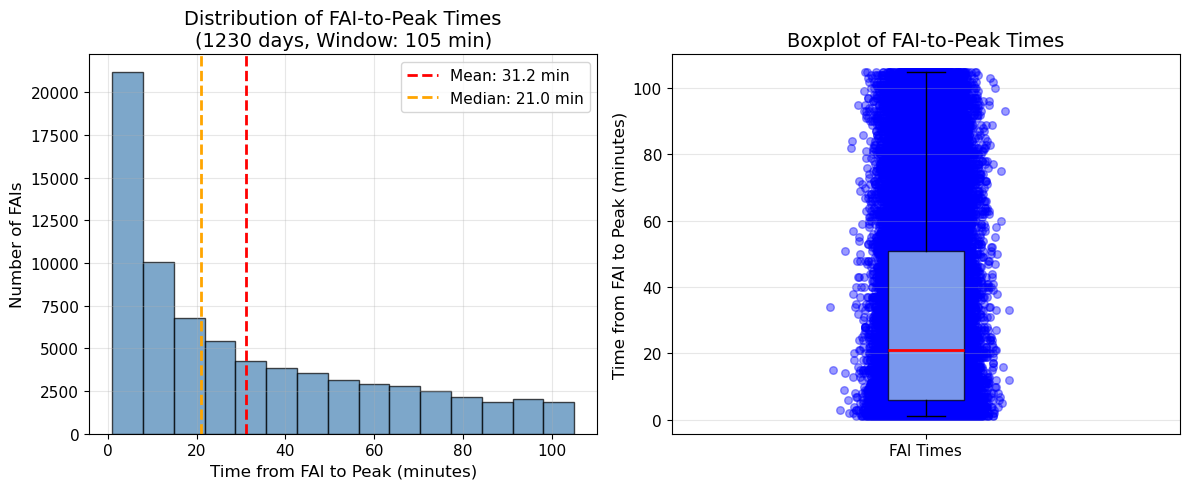

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window105min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 74342
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 105.0 minutos
Tiempo promedio: 31.2 minutos
Tiempo mediano: 21.0 minutos
Desviación estándar: 29.4 minutos
Percentil 25: 6.0 minutos
Percentil 75: 51.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_105min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


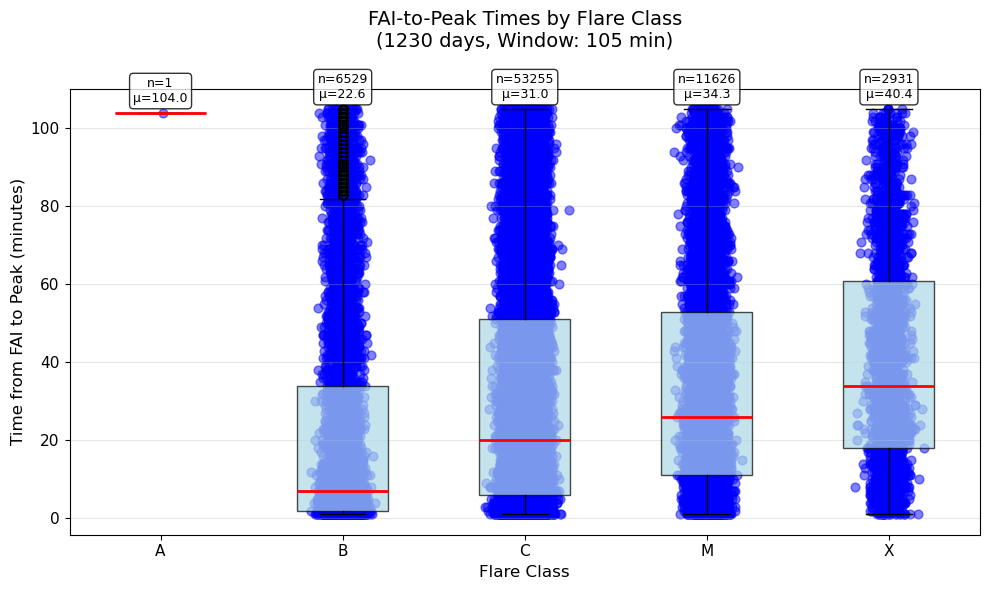

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window105min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase A:
  Count: 1
  Mean: 104.0 min
  Median: 104.0 min
  Std: 0.0 min
Clase B:
  Count: 6529
  Mean: 22.6 min
  Median: 7.0 min
  Std: 29.4 min
Clase C:
  Count: 53255
  Mean: 31.0 min
  Median: 20.0 min
  Std: 29.5 min
Clase M:
  Count: 11626
  Mean: 34.3 min
  Median: 26.0 min
  Std: 27.8 min
Clase X:
  Count: 2931
  Mean: 40.4 min
  Median: 34.0 min
  Std: 27.3 min
   ✅ Gráfica 3 guardada: fai_times_by_class_105min.png
📊 Procesando: df_fai_assoc_110min.csv (ventana: 110 min)


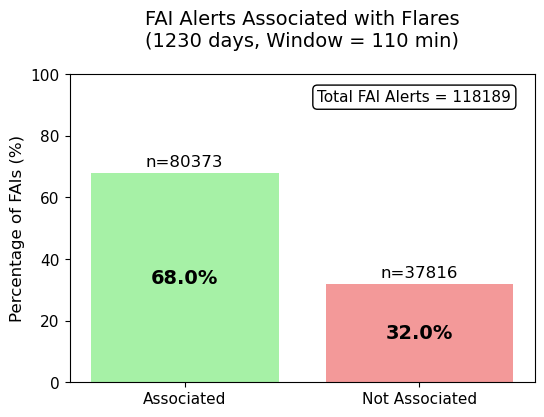

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window110min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 80373 (68.0%)
FAIs no asociados: 37816 (32.0%)
Ventana de asociación: 110 minutos
   ✅ Gráfica 1 guardada: association_summary_110min.png


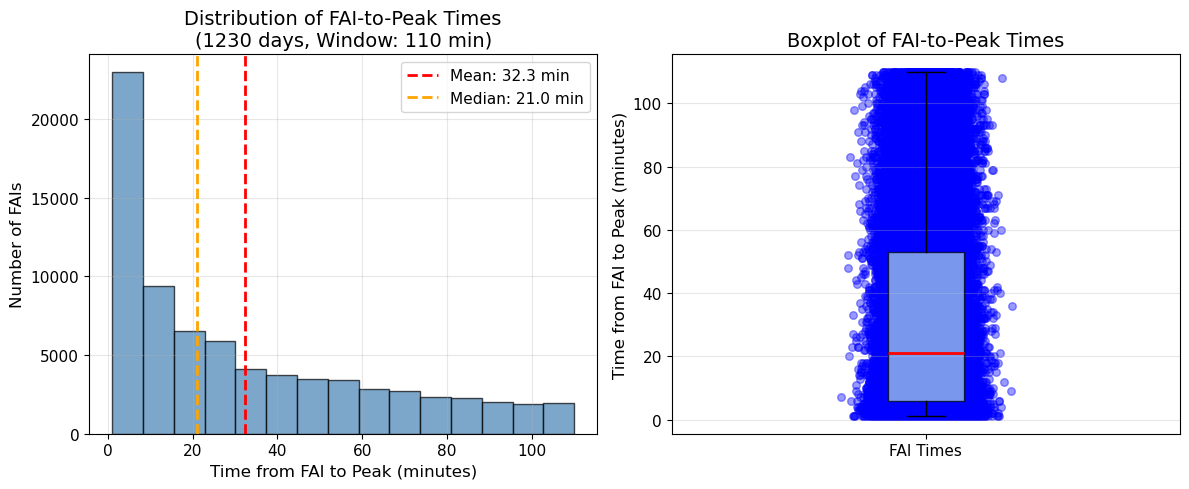

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window110min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 75510
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 110.0 minutos
Tiempo promedio: 32.3 minutos
Tiempo mediano: 21.0 minutos
Desviación estándar: 30.6 minutos
Percentil 25: 6.0 minutos
Percentil 75: 53.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_110min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


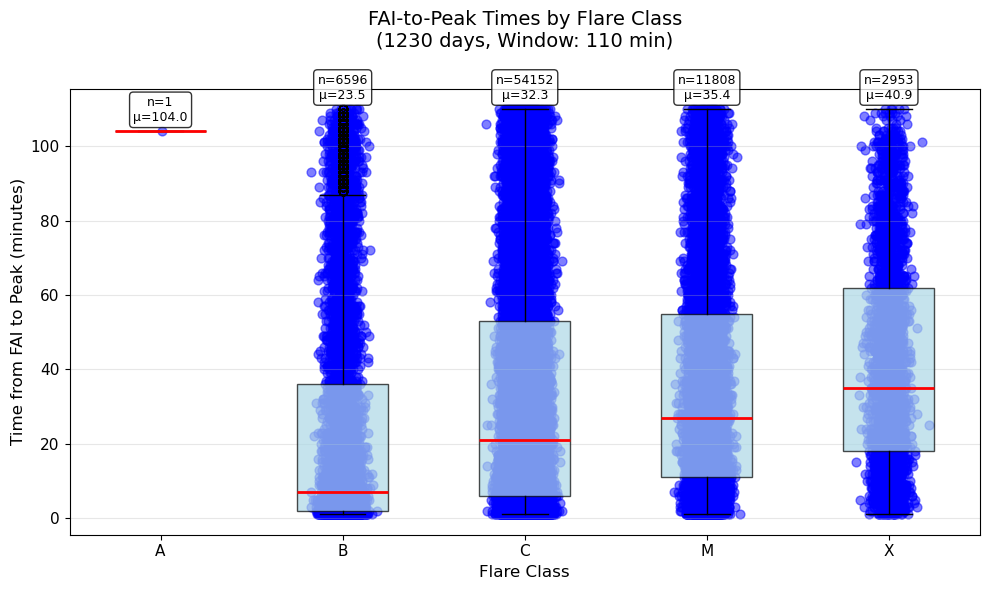

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window110min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase A:
  Count: 1
  Mean: 104.0 min
  Median: 104.0 min
  Std: 0.0 min
Clase B:
  Count: 6596
  Mean: 23.5 min
  Median: 7.0 min
  Std: 30.4 min
Clase C:
  Count: 54152
  Mean: 32.3 min
  Median: 21.0 min
  Std: 30.9 min
Clase M:
  Count: 11808
  Mean: 35.4 min
  Median: 27.0 min
  Std: 29.0 min
Clase X:
  Count: 2953
  Mean: 40.9 min
  Median: 35.0 min
  Std: 27.9 min
   ✅ Gráfica 3 guardada: fai_times_by_class_110min.png
📊 Procesando: df_fai_assoc_115min.csv (ventana: 115 min)


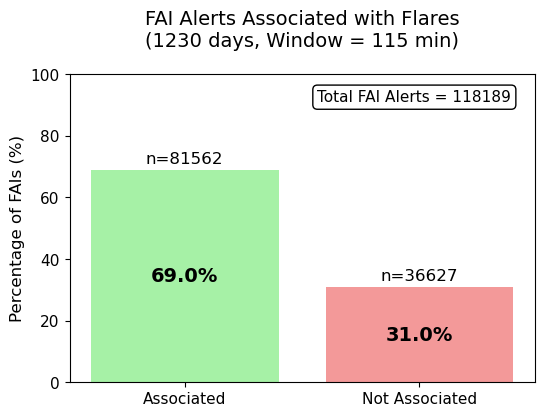

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window115min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 81562 (69.0%)
FAIs no asociados: 36627 (31.0%)
Ventana de asociación: 115 minutos
   ✅ Gráfica 1 guardada: association_summary_115min.png


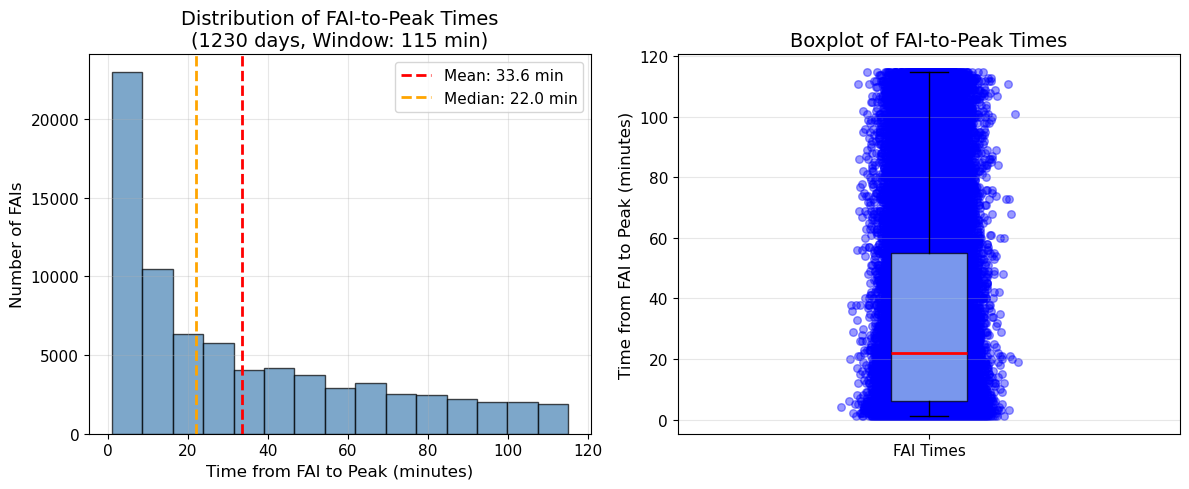

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window115min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 76699
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 115.0 minutos
Tiempo promedio: 33.6 minutos
Tiempo mediano: 22.0 minutos
Desviación estándar: 32.0 minutos
Percentil 25: 6.0 minutos
Percentil 75: 55.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_115min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


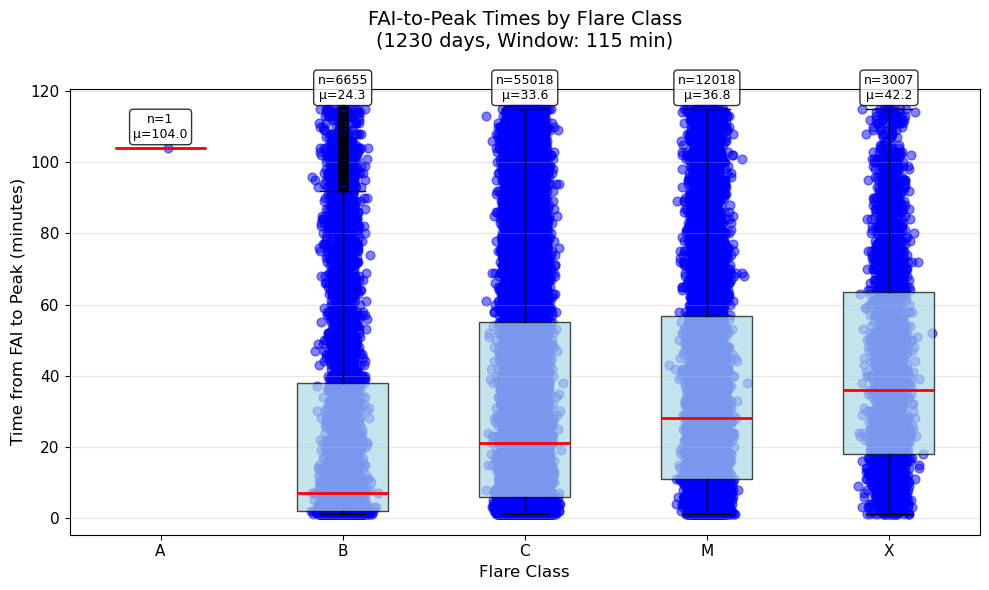

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window115min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase A:
  Count: 1
  Mean: 104.0 min
  Median: 104.0 min
  Std: 0.0 min
Clase B:
  Count: 6655
  Mean: 24.3 min
  Median: 7.0 min
  Std: 31.5 min
Clase C:
  Count: 55018
  Mean: 33.6 min
  Median: 21.0 min
  Std: 32.2 min
Clase M:
  Count: 12018
  Mean: 36.8 min
  Median: 28.0 min
  Std: 30.5 min
Clase X:
  Count: 3007
  Mean: 42.2 min
  Median: 36.0 min
  Std: 29.2 min
   ✅ Gráfica 3 guardada: fai_times_by_class_115min.png
📊 Procesando: df_fai_assoc_120min.csv (ventana: 120 min)


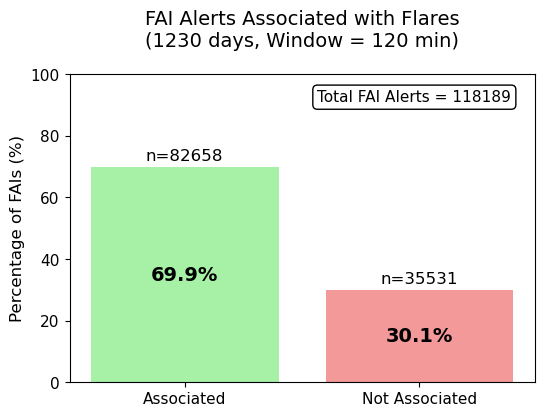

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window120min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 82658 (69.9%)
FAIs no asociados: 35531 (30.1%)
Ventana de asociación: 120 minutos
   ✅ Gráfica 1 guardada: association_summary_120min.png


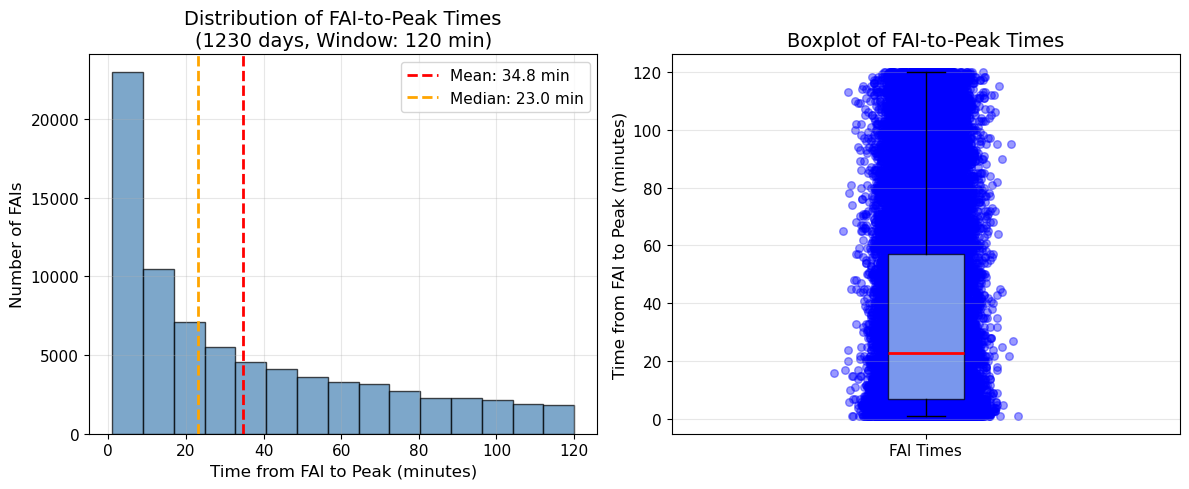

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window120min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 77795
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 120.0 minutos
Tiempo promedio: 34.8 minutos
Tiempo mediano: 23.0 minutos
Desviación estándar: 33.3 minutos
Percentil 25: 7.0 minutos
Percentil 75: 57.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_120min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


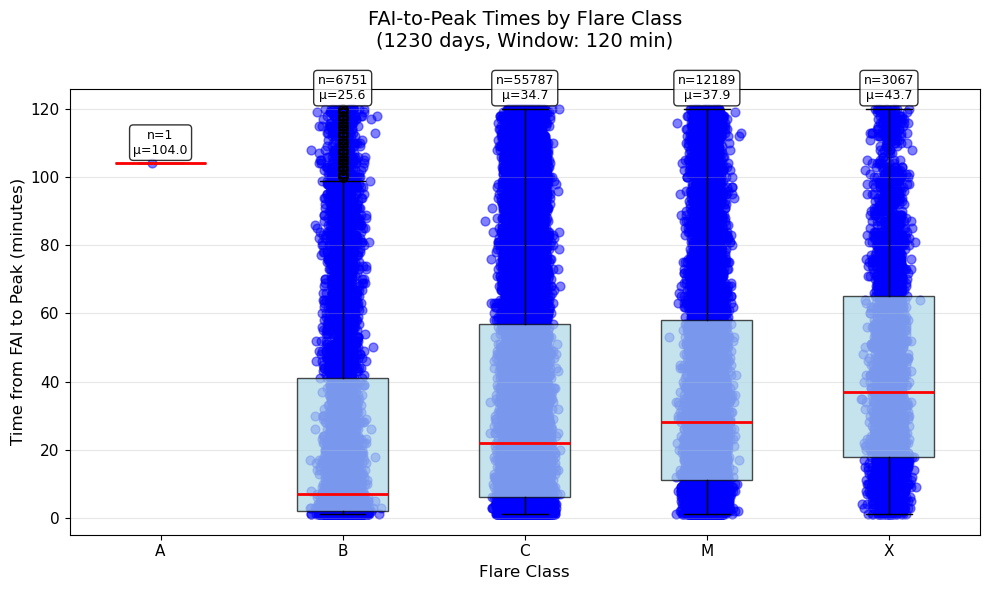

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window120min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase A:
  Count: 1
  Mean: 104.0 min
  Median: 104.0 min
  Std: 0.0 min
Clase B:
  Count: 6751
  Mean: 25.6 min
  Median: 7.0 min
  Std: 33.2 min
Clase C:
  Count: 55787
  Mean: 34.7 min
  Median: 22.0 min
  Std: 33.5 min
Clase M:
  Count: 12189
  Mean: 37.9 min
  Median: 28.0 min
  Std: 31.8 min
Clase X:
  Count: 3067
  Mean: 43.7 min
  Median: 37.0 min
  Std: 30.8 min
   ✅ Gráfica 3 guardada: fai_times_by_class_120min.png
📊 Procesando: df_fai_assoc_65min.csv (ventana: 65 min)


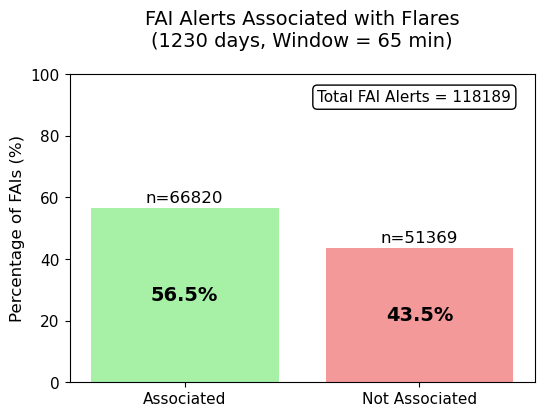

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window65min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 66820 (56.5%)
FAIs no asociados: 51369 (43.5%)
Ventana de asociación: 65 minutos
   ✅ Gráfica 1 guardada: association_summary_65min.png


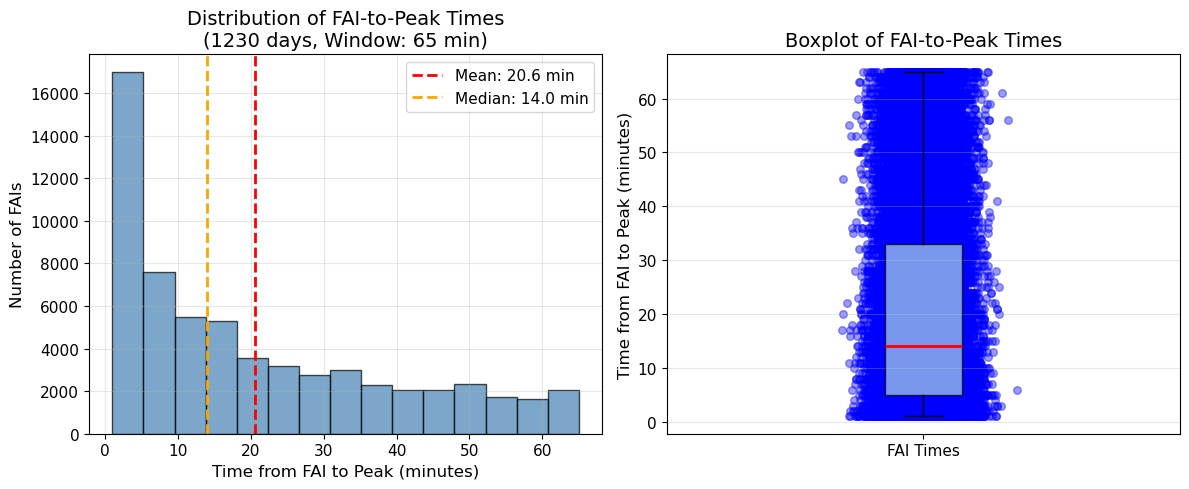

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window65min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 61957
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 65.0 minutos
Tiempo promedio: 20.6 minutos
Tiempo mediano: 14.0 minutos
Desviación estándar: 18.4 minutos
Percentil 25: 5.0 minutos
Percentil 75: 33.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_65min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


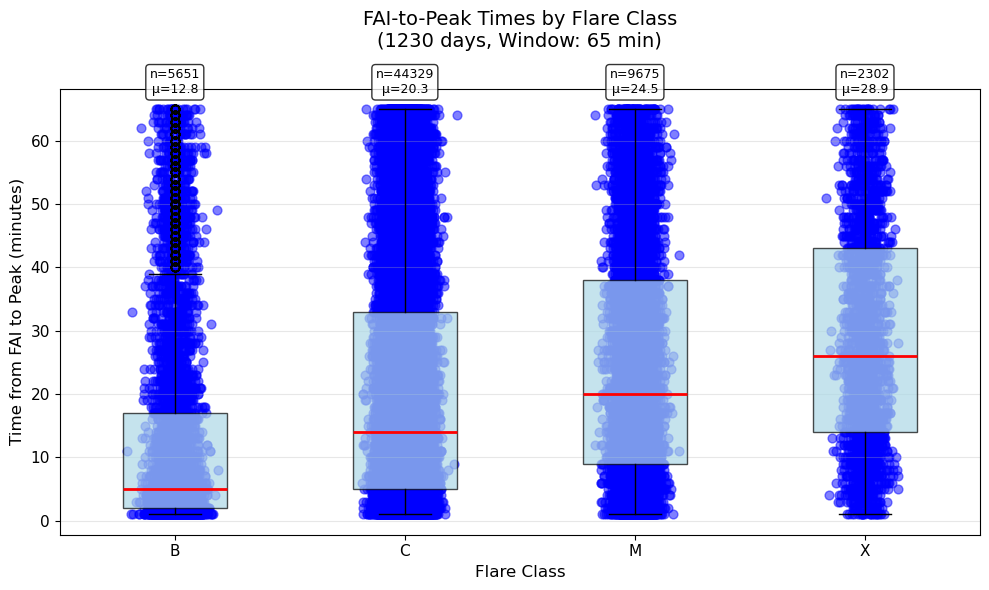

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window65min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 5651
  Mean: 12.8 min
  Median: 5.0 min
  Std: 16.3 min
Clase C:
  Count: 44329
  Mean: 20.3 min
  Median: 14.0 min
  Std: 18.4 min
Clase M:
  Count: 9675
  Mean: 24.5 min
  Median: 20.0 min
  Std: 18.0 min
Clase X:
  Count: 2302
  Mean: 28.9 min
  Median: 26.0 min
  Std: 17.5 min
   ✅ Gráfica 3 guardada: fai_times_by_class_65min.png
📊 Procesando: df_fai_assoc_70min.csv (ventana: 70 min)


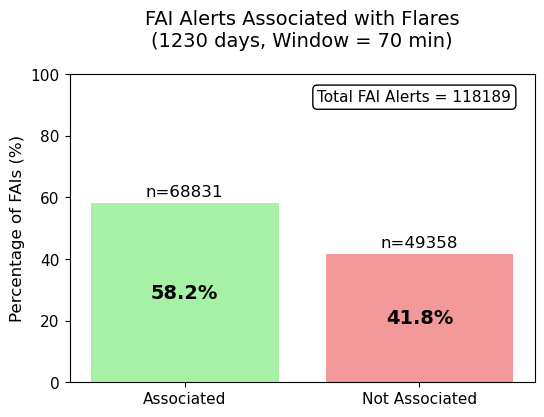

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window70min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 68831 (58.2%)
FAIs no asociados: 49358 (41.8%)
Ventana de asociación: 70 minutos
   ✅ Gráfica 1 guardada: association_summary_70min.png


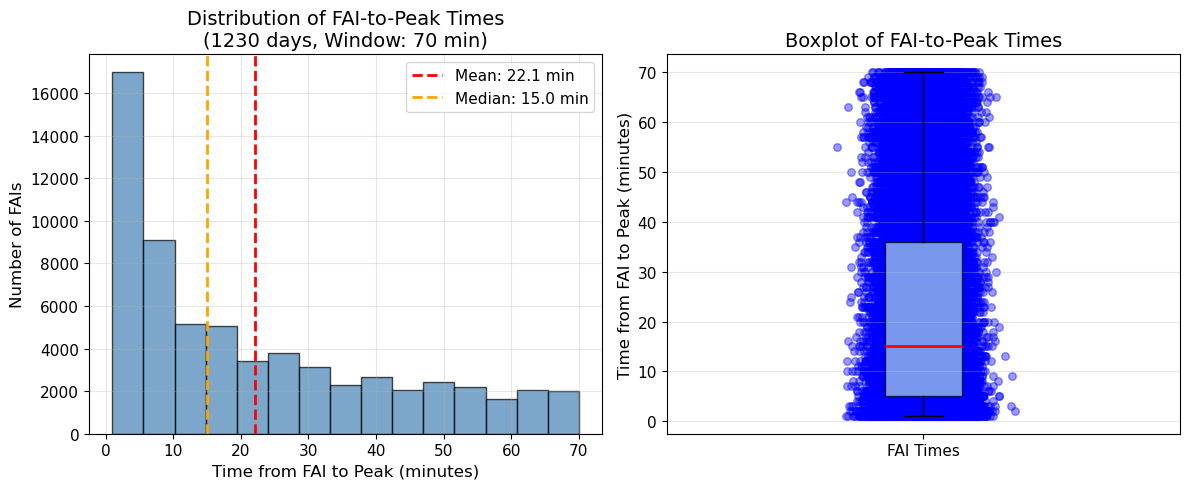

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window70min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 63968
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 70.0 minutos
Tiempo promedio: 22.1 minutos
Tiempo mediano: 15.0 minutos
Desviación estándar: 19.9 minutos
Percentil 25: 5.0 minutos
Percentil 75: 36.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_70min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


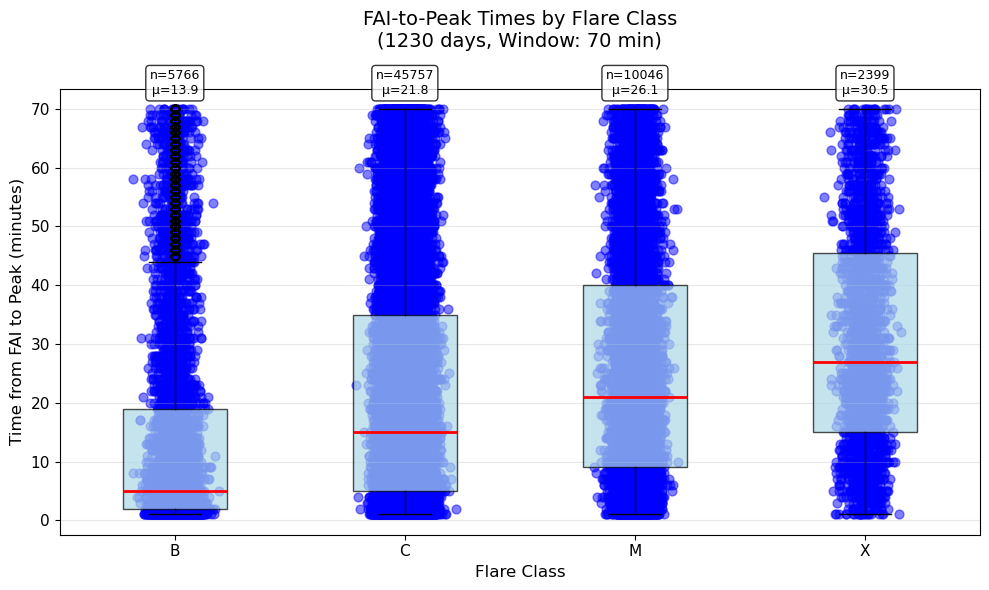

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window70min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 5766
  Mean: 13.9 min
  Median: 5.0 min
  Std: 17.9 min
Clase C:
  Count: 45757
  Mean: 21.8 min
  Median: 15.0 min
  Std: 19.9 min
Clase M:
  Count: 10046
  Mean: 26.1 min
  Median: 21.0 min
  Std: 19.5 min
Clase X:
  Count: 2399
  Mean: 30.5 min
  Median: 27.0 min
  Std: 18.8 min
   ✅ Gráfica 3 guardada: fai_times_by_class_70min.png
📊 Procesando: df_fai_assoc_75min.csv (ventana: 75 min)


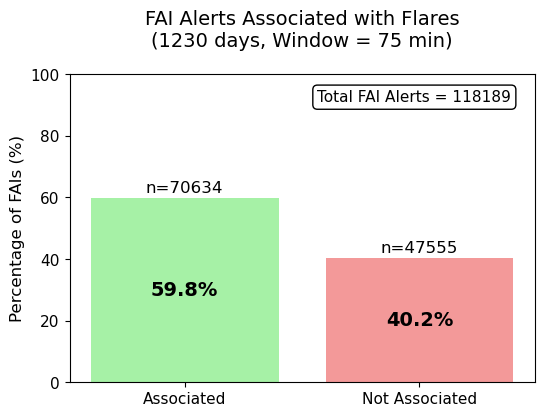

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window75min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 70634 (59.8%)
FAIs no asociados: 47555 (40.2%)
Ventana de asociación: 75 minutos
   ✅ Gráfica 1 guardada: association_summary_75min.png


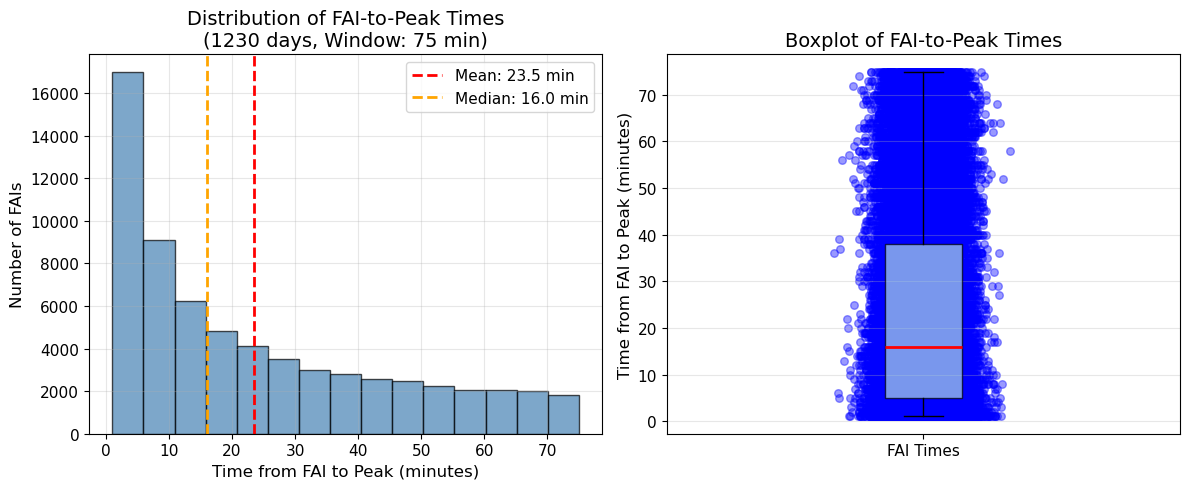

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window75min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 65771
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 75.0 minutos
Tiempo promedio: 23.5 minutos
Tiempo mediano: 16.0 minutos
Desviación estándar: 21.3 minutos
Percentil 25: 5.0 minutos
Percentil 75: 38.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_75min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


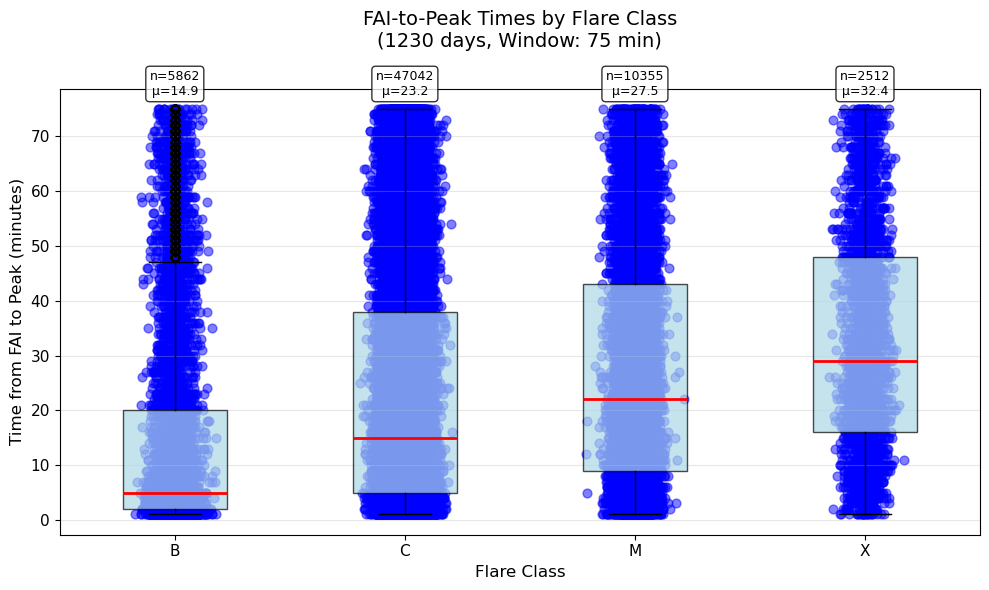

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window75min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 5862
  Mean: 14.9 min
  Median: 5.0 min
  Std: 19.3 min
Clase C:
  Count: 47042
  Mean: 23.2 min
  Median: 15.0 min
  Std: 21.3 min
Clase M:
  Count: 10355
  Mean: 27.5 min
  Median: 22.0 min
  Std: 20.8 min
Clase X:
  Count: 2512
  Mean: 32.4 min
  Median: 29.0 min
  Std: 20.3 min
   ✅ Gráfica 3 guardada: fai_times_by_class_75min.png
📊 Procesando: df_fai_assoc_80min.csv (ventana: 80 min)


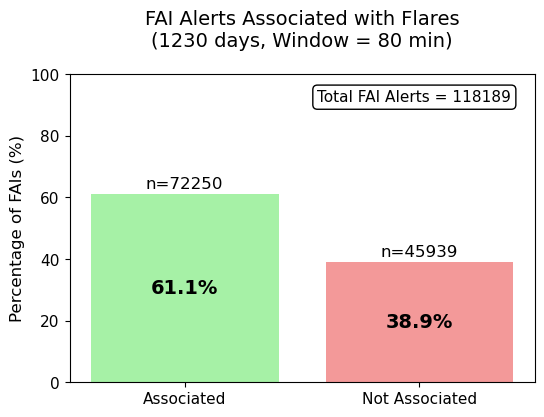

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window80min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 72250 (61.1%)
FAIs no asociados: 45939 (38.9%)
Ventana de asociación: 80 minutos
   ✅ Gráfica 1 guardada: association_summary_80min.png


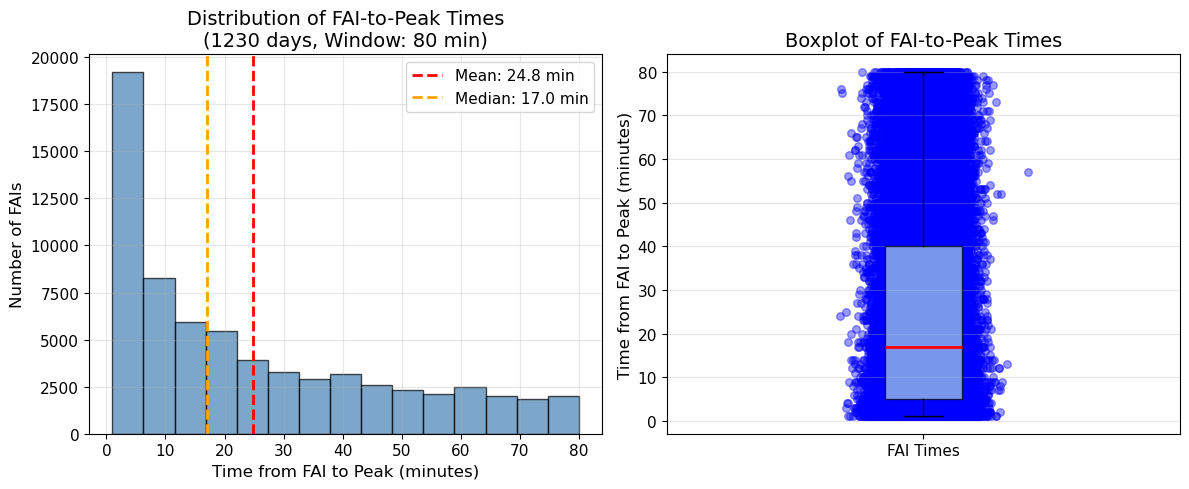

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window80min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 67387
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 80.0 minutos
Tiempo promedio: 24.8 minutos
Tiempo mediano: 17.0 minutos
Desviación estándar: 22.7 minutos
Percentil 25: 5.0 minutos
Percentil 75: 40.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_80min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


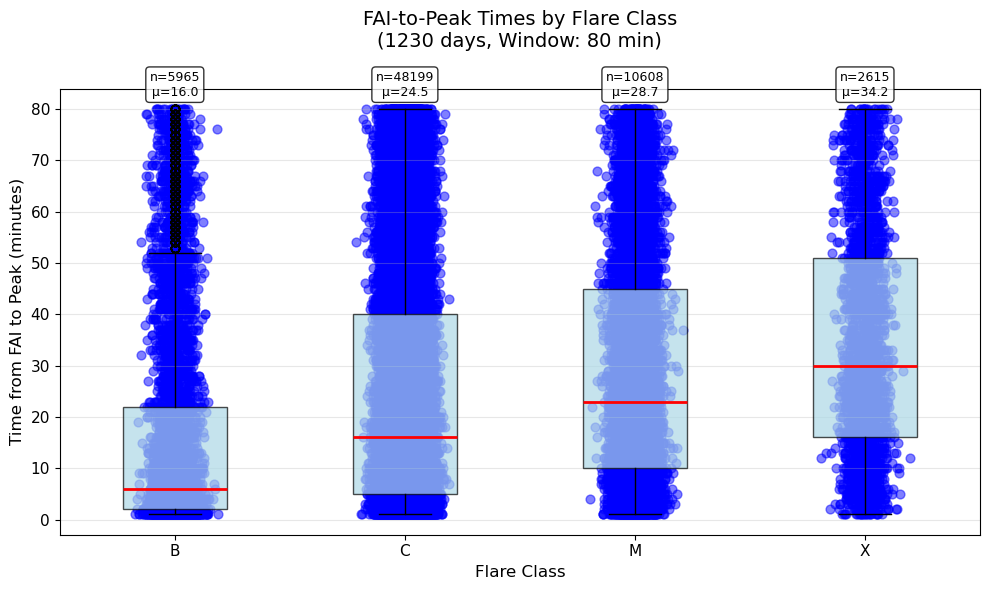

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window80min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 5965
  Mean: 16.0 min
  Median: 6.0 min
  Std: 20.8 min
Clase C:
  Count: 48199
  Mean: 24.5 min
  Median: 16.0 min
  Std: 22.7 min
Clase M:
  Count: 10608
  Mean: 28.7 min
  Median: 23.0 min
  Std: 22.0 min
Clase X:
  Count: 2615
  Mean: 34.2 min
  Median: 30.0 min
  Std: 21.8 min
   ✅ Gráfica 3 guardada: fai_times_by_class_80min.png
📊 Procesando: df_fai_assoc_85min.csv (ventana: 85 min)


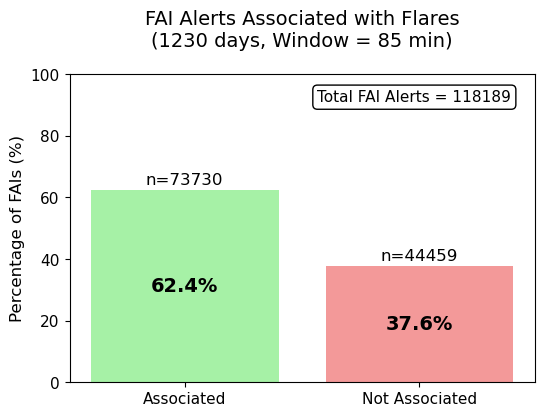

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window85min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 73730 (62.4%)
FAIs no asociados: 44459 (37.6%)
Ventana de asociación: 85 minutos
   ✅ Gráfica 1 guardada: association_summary_85min.png


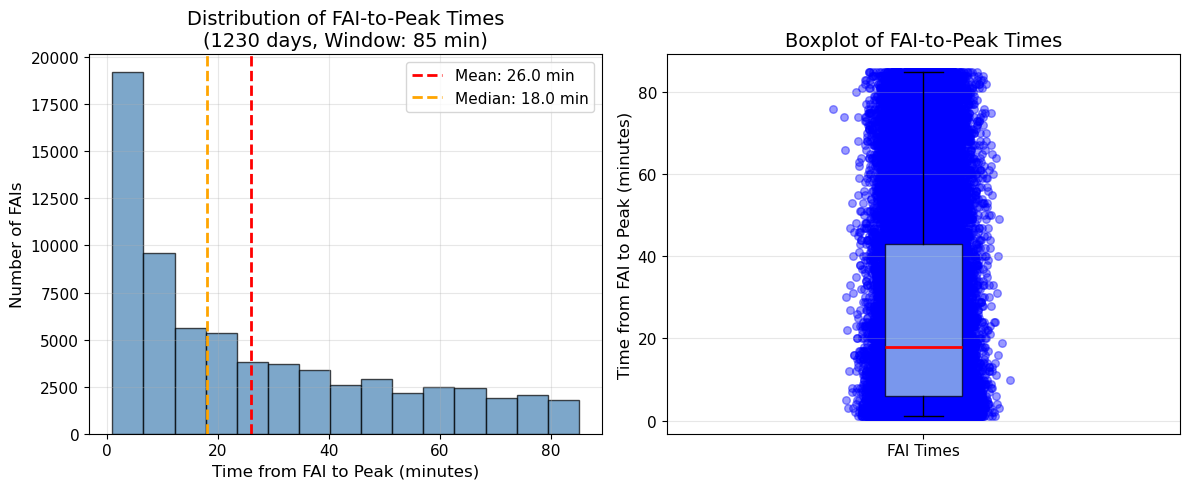

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window85min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 68867
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 85.0 minutos
Tiempo promedio: 26.0 minutos
Tiempo mediano: 18.0 minutos
Desviación estándar: 24.0 minutos
Percentil 25: 6.0 minutos
Percentil 75: 43.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_85min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


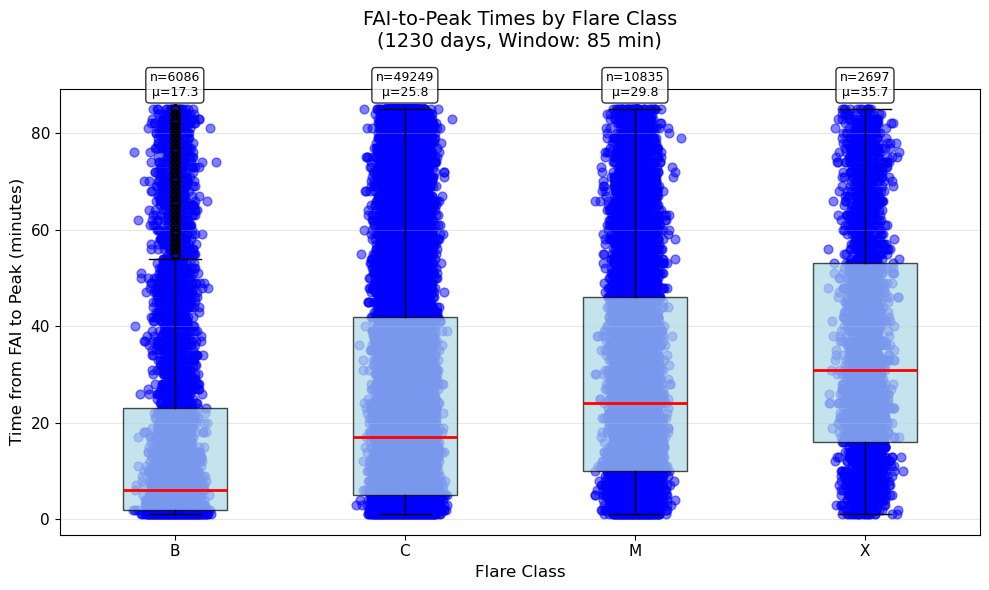

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window85min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 6086
  Mean: 17.3 min
  Median: 6.0 min
  Std: 22.6 min
Clase C:
  Count: 49249
  Mean: 25.8 min
  Median: 17.0 min
  Std: 24.0 min
Clase M:
  Count: 10835
  Mean: 29.8 min
  Median: 24.0 min
  Std: 23.1 min
Clase X:
  Count: 2697
  Mean: 35.7 min
  Median: 31.0 min
  Std: 23.0 min
   ✅ Gráfica 3 guardada: fai_times_by_class_85min.png
📊 Procesando: df_fai_assoc_90min.csv (ventana: 90 min)


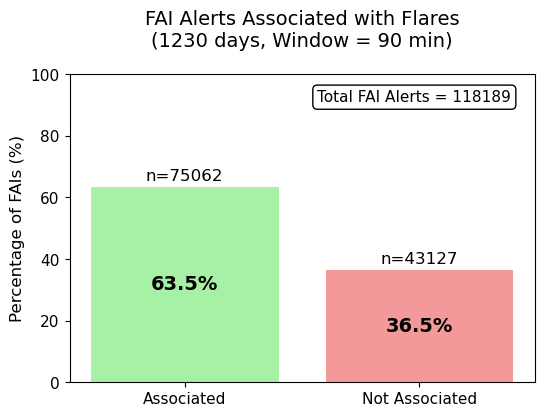

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window90min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 75062 (63.5%)
FAIs no asociados: 43127 (36.5%)
Ventana de asociación: 90 minutos
   ✅ Gráfica 1 guardada: association_summary_90min.png


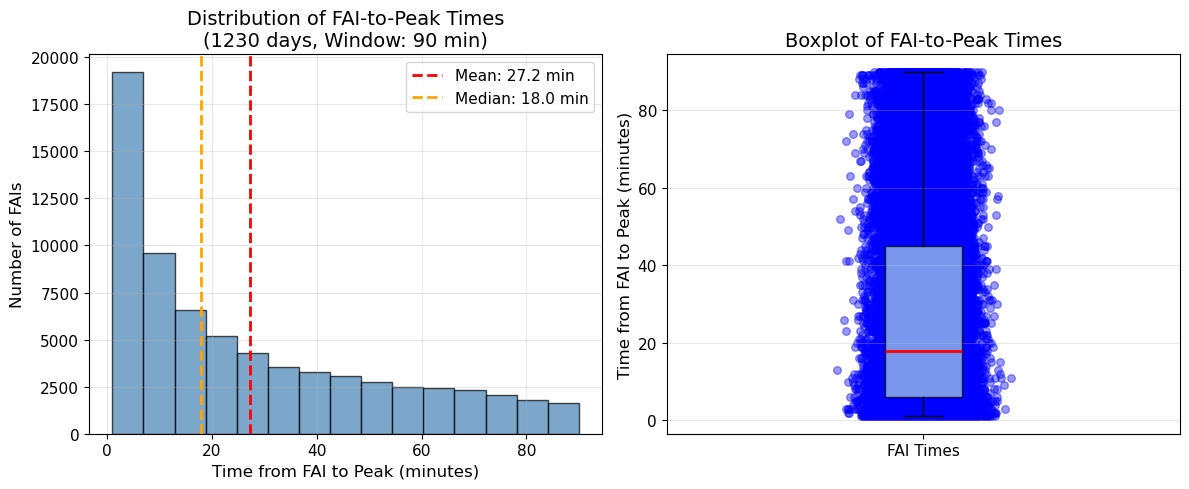

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window90min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 70199
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 90.0 minutos
Tiempo promedio: 27.2 minutos
Tiempo mediano: 18.0 minutos
Desviación estándar: 25.2 minutos
Percentil 25: 6.0 minutos
Percentil 75: 45.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_90min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


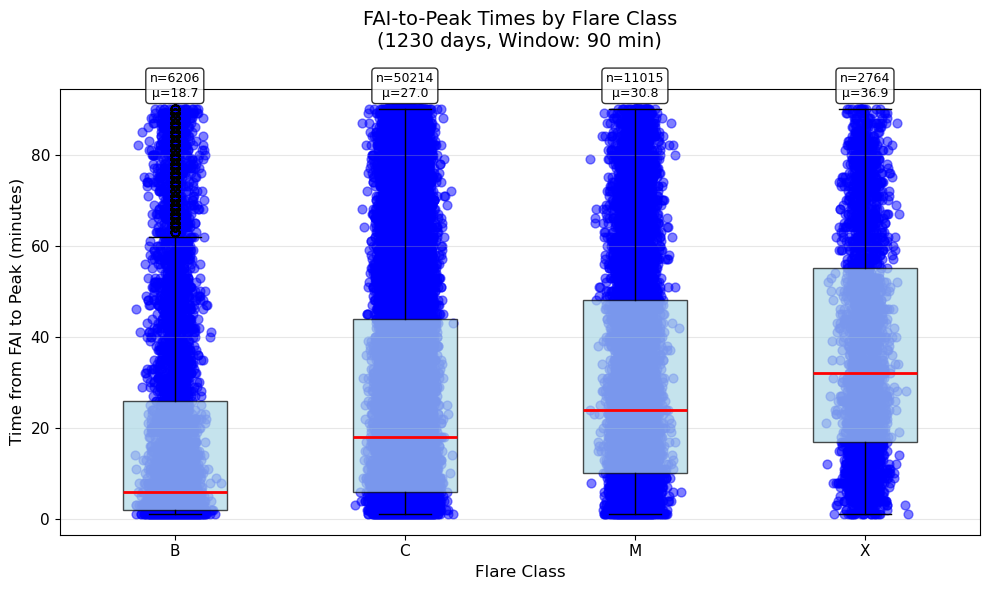

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window90min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 6206
  Mean: 18.7 min
  Median: 6.0 min
  Std: 24.4 min
Clase C:
  Count: 50214
  Mean: 27.0 min
  Median: 18.0 min
  Std: 25.2 min
Clase M:
  Count: 11015
  Mean: 30.8 min
  Median: 24.0 min
  Std: 24.0 min
Clase X:
  Count: 2764
  Mean: 36.9 min
  Median: 32.0 min
  Std: 24.1 min
   ✅ Gráfica 3 guardada: fai_times_by_class_90min.png
📊 Procesando: df_fai_assoc_95min.csv (ventana: 95 min)


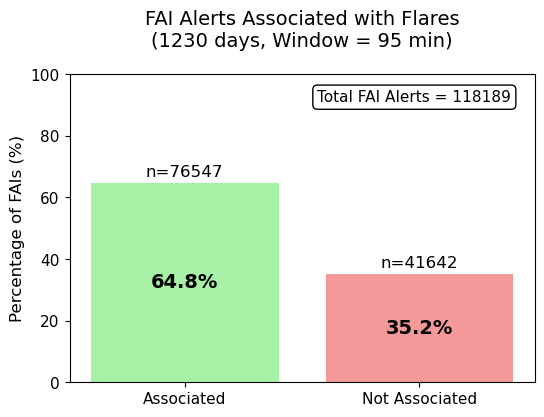

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_associated_Flares_Window95min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 118189
FAIs asociados a flares: 76547 (64.8%)
FAIs no asociados: 41642 (35.2%)
Ventana de asociación: 95 minutos
   ✅ Gráfica 1 guardada: association_summary_95min.png


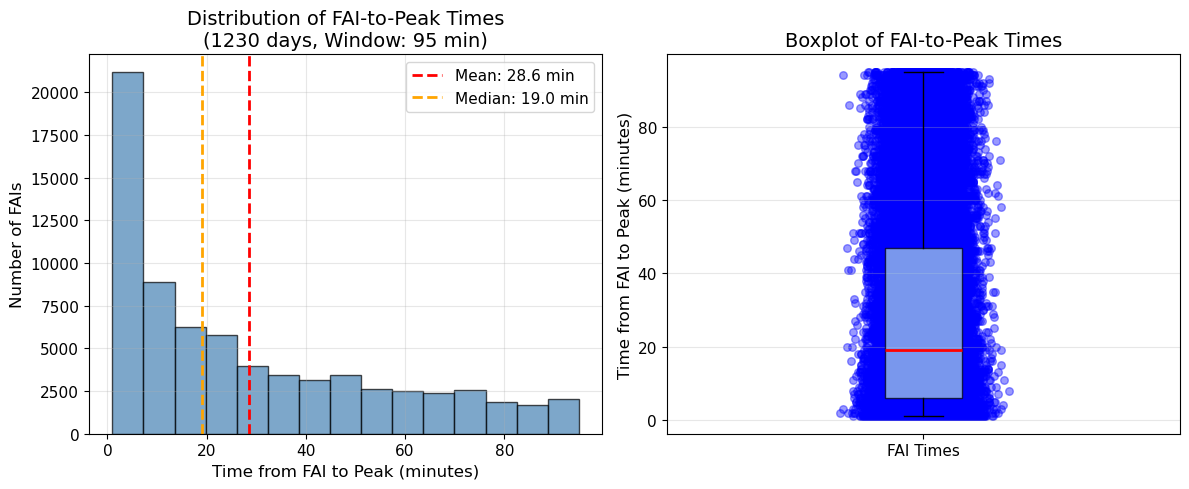

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_to_Peak_Times_Distribution_Window95min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 71684
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 95.0 minutos
Tiempo promedio: 28.6 minutos
Tiempo mediano: 19.0 minutos
Desviación estándar: 26.6 minutos
Percentil 25: 6.0 minutos
Percentil 75: 47.0 minutos
   ✅ Gráfica 2 guardada: fai_to_peak_times_95min.png


/tmp/ipykernel_7303/3129066925.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,


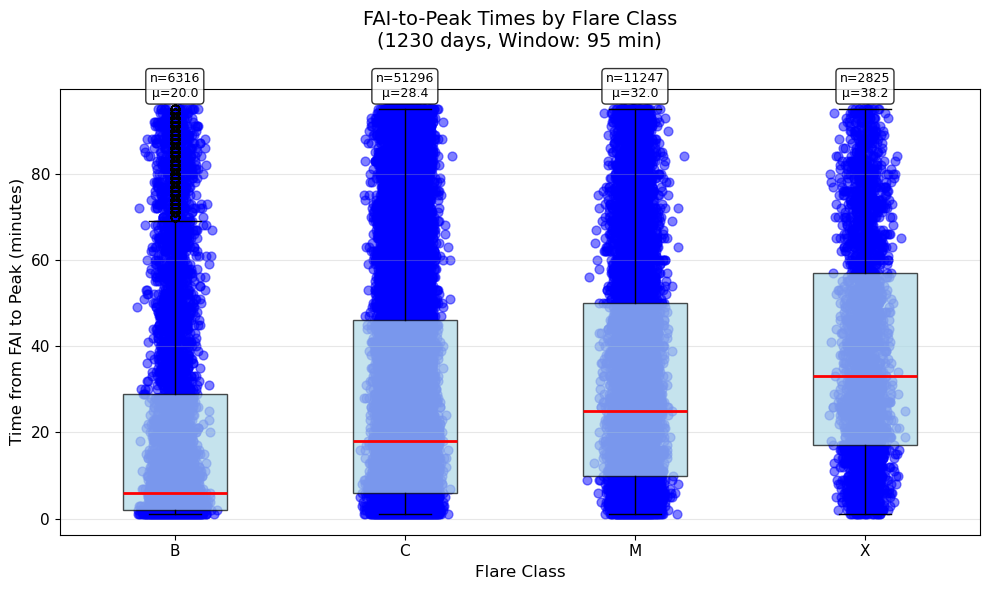

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_FAI_Times_by_Class_Window95min.png

=== TIEMPOS POR CLASE DE FLARE ===
Clase B:
  Count: 6316
  Mean: 20.0 min
  Median: 6.0 min
  Std: 26.1 min
Clase C:
  Count: 51296
  Mean: 28.4 min
  Median: 18.0 min
  Std: 26.7 min
Clase M:
  Count: 11247
  Mean: 32.0 min
  Median: 25.0 min
  Std: 25.4 min
Clase X:
  Count: 2825
  Mean: 38.2 min
  Median: 33.0 min
  Std: 25.2 min
   ✅ Gráfica 3 guardada: fai_times_by_class_95min.png
🎯 Gráficas de asociación guardadas en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/association_plots


'2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/association_plots'

In [215]:
# Solo gráficas de asociación
plot_existing_association_analysis(association_dir, n_days)

## Función para leer y graficar ANÁLISIS DE ANTICIPACIÓN

###  FAI association

In [216]:
def plot_fai_association(df_anticipation_time, n_days, window_minutes, fai_column="FAIalerts_W"):
    """
    Genera una gráfica de barras mostrando cuántos flares tienen FAIs asociados.
    Con porcentaje dentro de la barra y número total encima.
    
    Parámetros:
    - df_anticipation_time: DataFrame con datos de anticipación FAI
    - n_days: número de días (para título)
    - window_minutes: ventana de tiempo (para título)
    - fai_column: nombre de la columna que indica si hay FAI asociado
    """
    df = df_anticipation_time.copy()
    window=fai_column
    # Verificar que la columna FAI existe
    if fai_column not in df.columns:
        available_columns = [col for col in df.columns if 'FAI' in col]
        raise ValueError(f"Columna '{fai_column}' no encontrada. Columnas disponibles con FAI: {available_columns}")
    
    print(f"Usando columna FAI: {fai_column}")
    
    # Convertir a booleano (si es numérica)
    if df[fai_column].dtype in ['int64', 'float64']:
        df['FAI_bool'] = df[fai_column] > 0
    else:
        df['FAI_bool'] = df[fai_column].astype(bool)

    # Contar cuántos flares tienen FAI y cuántos no
    counts = df['FAI_bool'].value_counts()
    total = counts.sum()
    
    # Reordenar para que True = With FAI aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)
    
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14
    })

    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['With FAI', 'Without FAI'])
    ax.set_ylabel("Percentage of Flares (%)")
    ax.set_title(f"Flares with Associated FAIs ({n_days} days, Window = {window_minutes} min, {window})",
                 pad=20)
    
    # Agregar porcentaje dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')
    
    # Agregar número total arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")
    
    # Leyenda con total de flares en esquina superior derecha
    ax.text(0.95, 0.95, f"Total Flares = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    flares_with_fai = counts.get(True, 0)
    flares_without_fai = counts.get(False, 0)
    
    print(f"\n--- Estadísticas FAI ---")
    print(f"Total flares analizados: {total}")
    print(f"Flares con FAI: {flares_with_fai} ({percentages.get(True, 0):.1f}%)")
    print(f"Flares sin FAI: {flares_without_fai} ({percentages.get(False, 0):.1f}%)")
    print(f"Columna FAI utilizada: {fai_column}")



In [217]:
def plot_fai_association_for_all_windows(base_dir, n_days, fai_columns=None):
    """
    Ejecuta plot_fai_association para todos los archivos de ventanas encontrados
    
    Parámetros:
    - base_dir: directorio con los archivos CSV
    - n_days: número de días para el título
    - fai_columns: lista de columnas FAI a graficar (opcional)
    """
    if fai_columns is None:
        fai_columns = ['FAIalerts_W', 'FAIalerts_StartPeak', 'FAIalerts_WStart']
    
    # Encontrar todos los archivos CSV en el directorio
    pattern = os.path.join(base_dir, "df_anticipation_*.csv")
    csv_files = glob.glob(pattern)
    
    if not csv_files:
        print(f"❌ No se encontraron archivos en: {base_dir}")
        return
    
    print(f"📁 Encontrados {len(csv_files)} archivos en: {base_dir}")
    
    # Crear directorio para gráficas
    association_graphics_dir = os.path.join(graphics_dir, "Flares_asociatad_fai_plots")
    os.makedirs(association_graphics_dir, exist_ok=True)
    
    for csv_file in sorted(csv_files):
        try:
            # Extraer window_minutes del nombre del archivo
            filename = os.path.basename(csv_file)
            window_minutes = int(filename.split('_')[2].replace('min.csv', ''))
            
            print(f"\n📊 Procesando: {filename} (ventana: {window_minutes} min)")
            
            # Leer el archivo
            df_anticipation = pd.read_csv(csv_file)
            
            # Verificar columnas disponibles
            print(f"   📋 Columnas disponibles: {[col for col in df_anticipation.columns if 'FAI' in col]}")
            
            # Procesar cada columna FAI
            for fai_column in fai_columns:
                if fai_column in df_anticipation.columns:
                    print(f"   📊 Generando gráfica para {fai_column}...")
                    
                    try:
                        plot_fai_association(
                            df_anticipation_time=df_anticipation,
                            n_days=n_days,
                            window_minutes=window_minutes,
                            fai_column=fai_column
                        )
                        
                        # Mover y renombrar la gráfica
                        original_plot = f"{n_days}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
                        new_plot = f"Flares_associated_{fai_column}_{window_minutes}min.png"
                        original_path = os.path.join(graphics_dir, original_plot)
                        new_path = os.path.join(association_graphics_dir, new_plot)
                        
                        if os.path.exists(original_path):
                            os.rename(original_path, new_path)
                            print(f"   ✅ Gráfica {fai_column} guardada: {new_plot}")
                        else:
                            print(f"   ❌ No se encontró la gráfica: {original_plot}")
                            
                    except Exception as e:
                        print(f"   ❌ Error en {fai_column}: {e}")
                        continue
                else:
                    print(f"   ⚠️  Columna {fai_column} no encontrada en este archivo")
                    
        except Exception as e:
            print(f"   ❌ Error procesando {csv_file}: {e}")
            continue
    
    print(f"\n🎯 Todas las gráficas de asociación guardadas en: {association_graphics_dir}")
    return association_graphics_dir

# EJECUTAR PARA TODAS LAS VENTANAS
# Asegúrate de que estas variables estén definidas:
# base_dir = "tu_directorio_con_archivos_csv"
# n_days = 7  # o el número que uses



📁 Encontrados 12 archivos en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/anticipation_analysis_65to120_step5

📊 Procesando: df_anticipation_100min.csv (ventana: 100 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


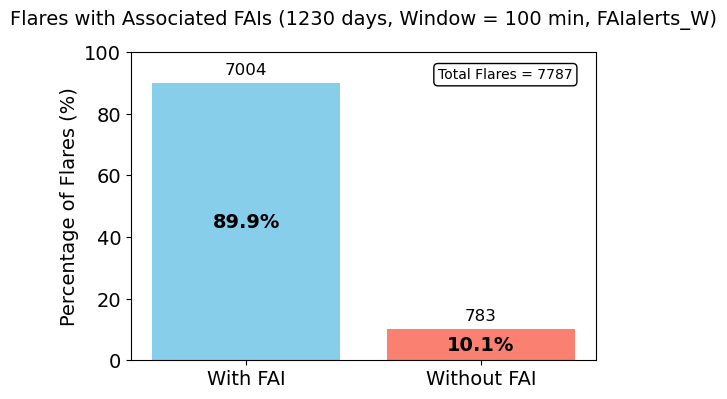

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window100min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7004 (89.9%)
Flares sin FAI: 783 (10.1%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_100min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


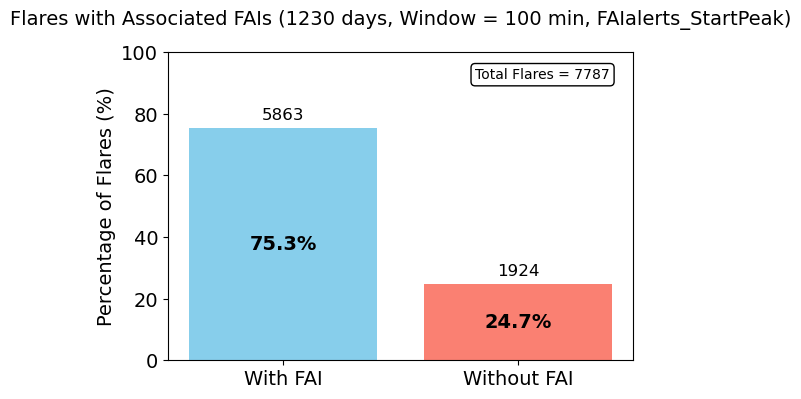

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window100min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_100min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


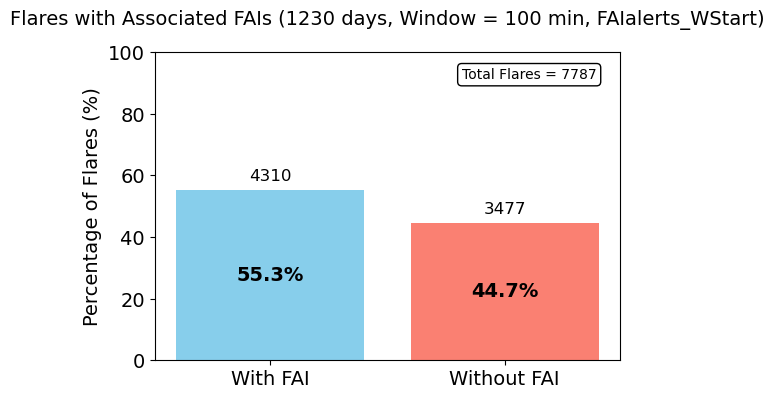

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window100min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4310 (55.3%)
Flares sin FAI: 3477 (44.7%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_100min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


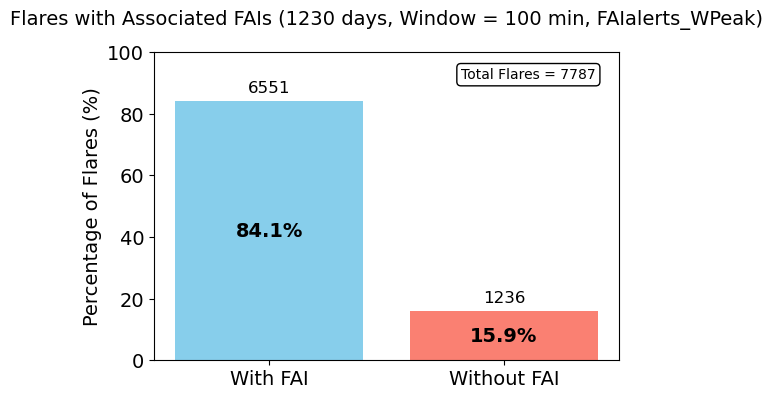

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window100min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6551 (84.1%)
Flares sin FAI: 1236 (15.9%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_100min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


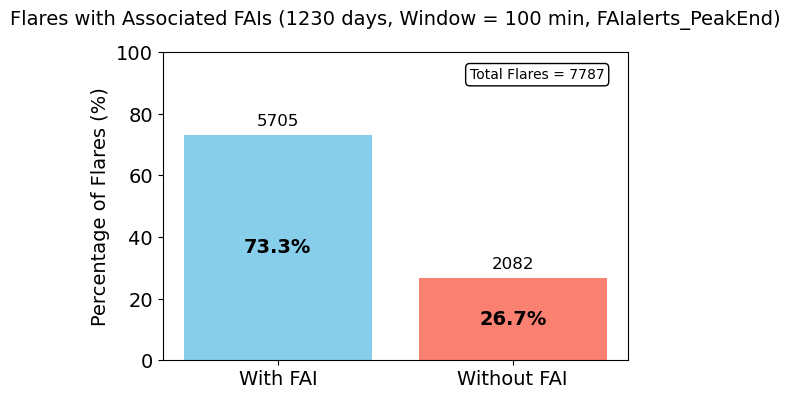

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window100min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_100min.png

📊 Procesando: df_anticipation_105min.csv (ventana: 105 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


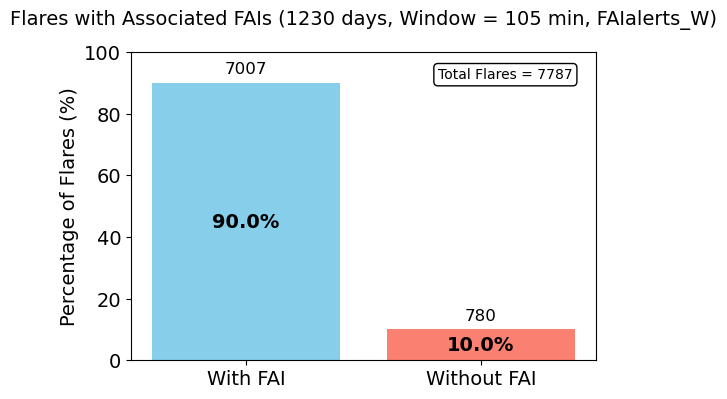

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window105min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7007 (90.0%)
Flares sin FAI: 780 (10.0%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_105min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


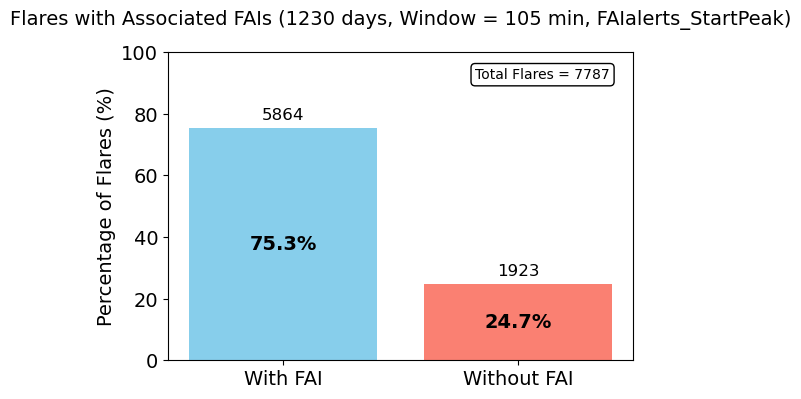

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window105min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5864 (75.3%)
Flares sin FAI: 1923 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_105min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


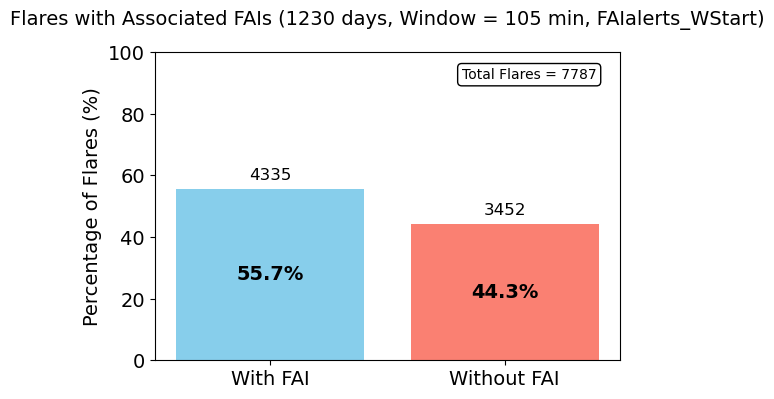

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window105min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4335 (55.7%)
Flares sin FAI: 3452 (44.3%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_105min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


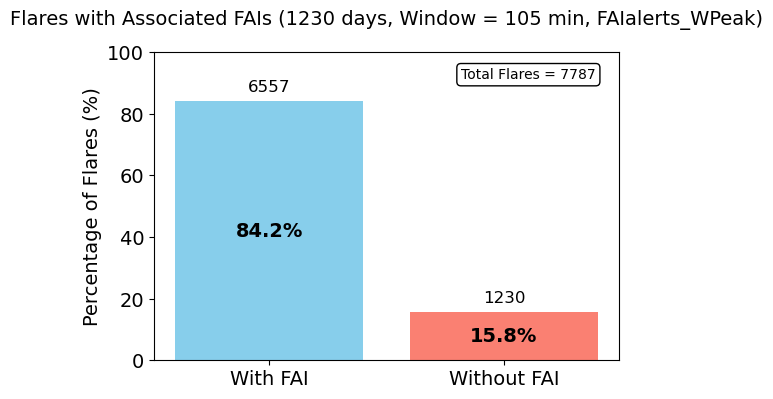

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window105min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6557 (84.2%)
Flares sin FAI: 1230 (15.8%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_105min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


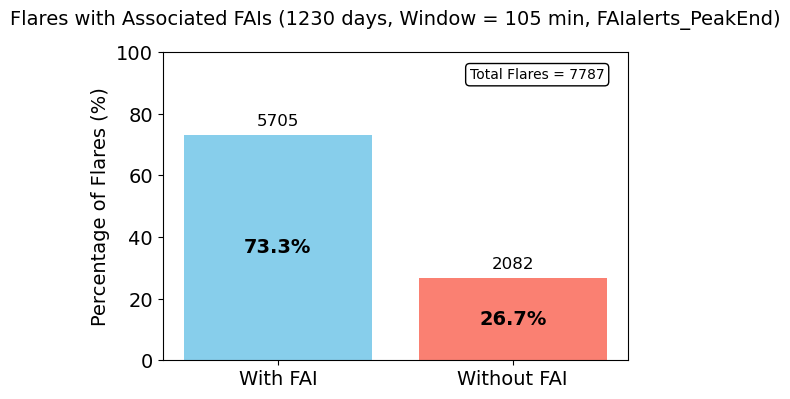

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window105min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_105min.png

📊 Procesando: df_anticipation_110min.csv (ventana: 110 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


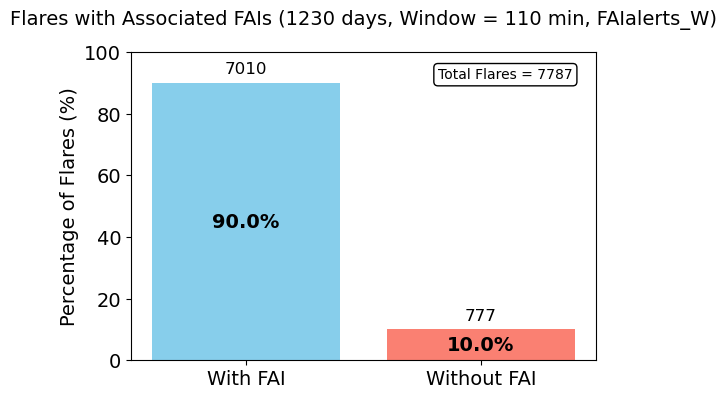

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window110min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7010 (90.0%)
Flares sin FAI: 777 (10.0%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_110min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


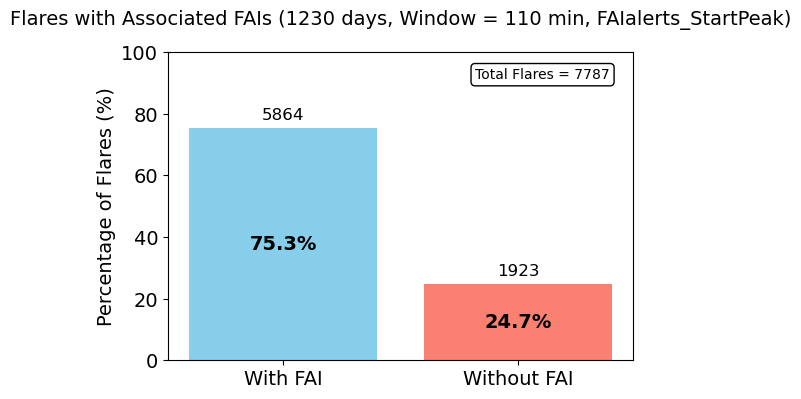

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window110min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5864 (75.3%)
Flares sin FAI: 1923 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_110min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


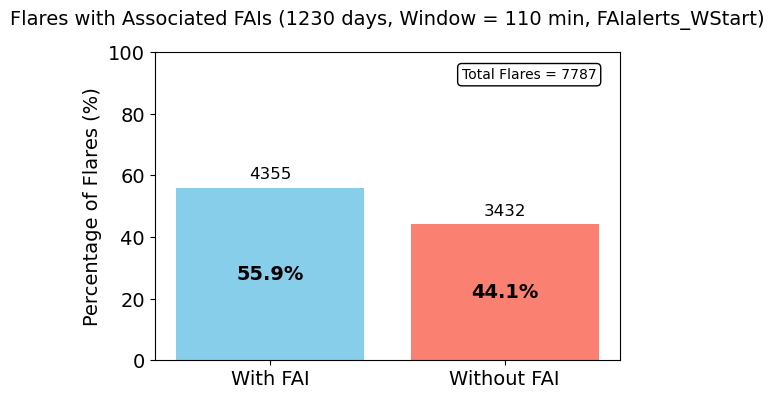

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window110min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4355 (55.9%)
Flares sin FAI: 3432 (44.1%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_110min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


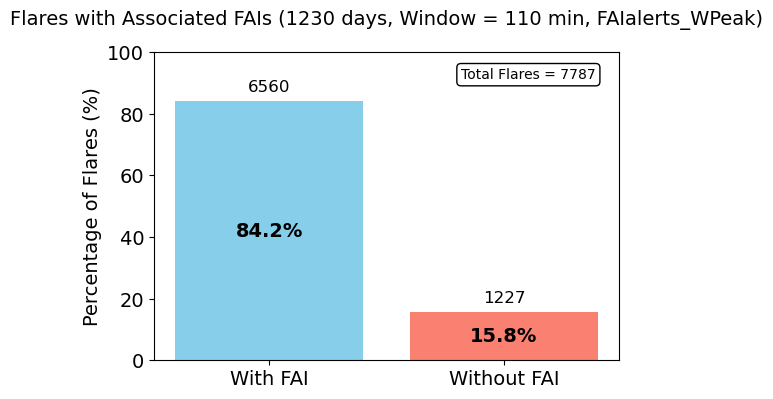

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window110min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6560 (84.2%)
Flares sin FAI: 1227 (15.8%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_110min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


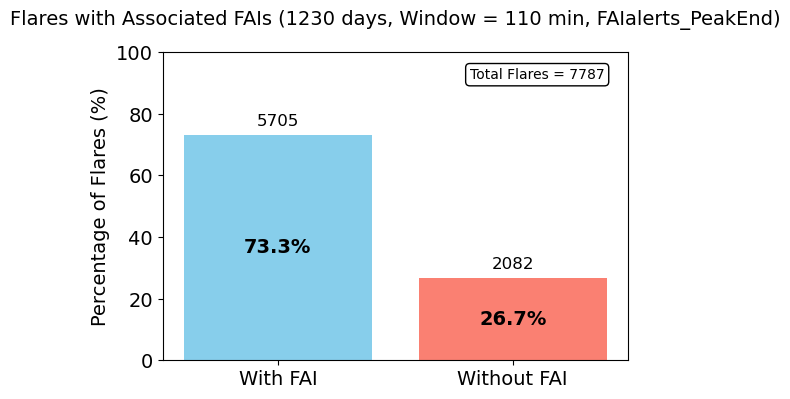

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window110min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_110min.png

📊 Procesando: df_anticipation_115min.csv (ventana: 115 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


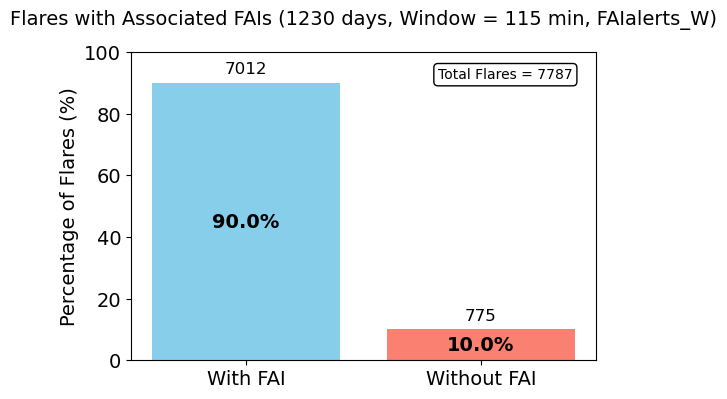

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window115min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7012 (90.0%)
Flares sin FAI: 775 (10.0%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_115min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


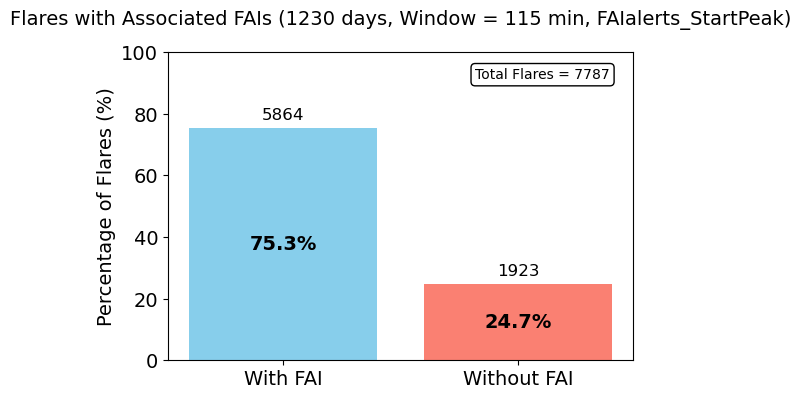

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window115min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5864 (75.3%)
Flares sin FAI: 1923 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_115min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


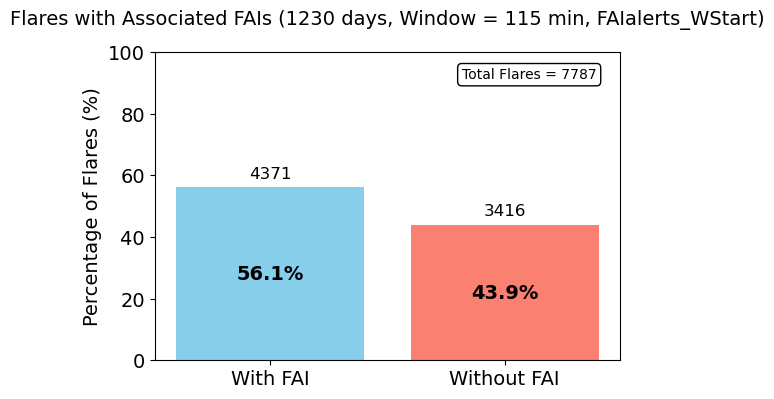

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window115min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4371 (56.1%)
Flares sin FAI: 3416 (43.9%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_115min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


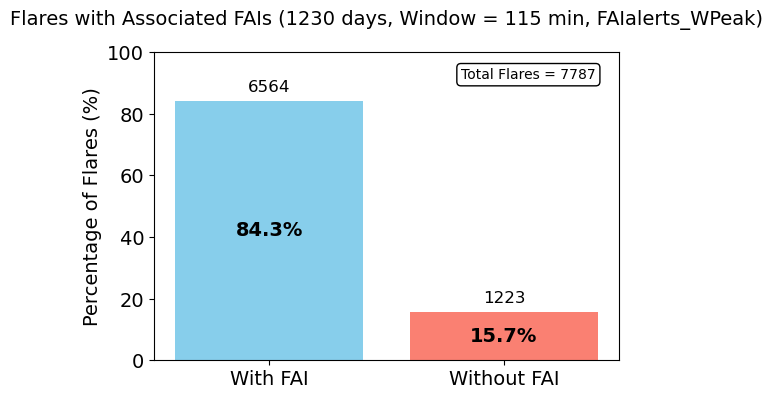

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window115min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6564 (84.3%)
Flares sin FAI: 1223 (15.7%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_115min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


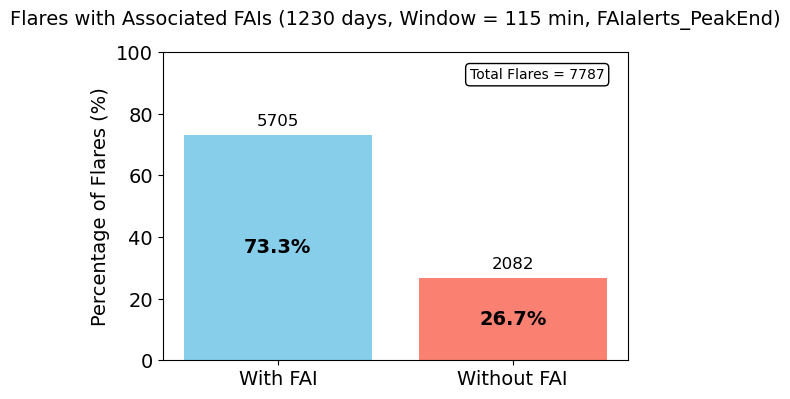

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window115min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_115min.png

📊 Procesando: df_anticipation_120min.csv (ventana: 120 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


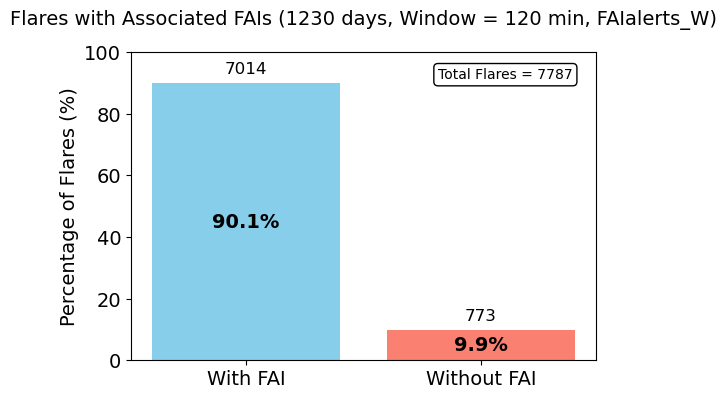

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window120min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7014 (90.1%)
Flares sin FAI: 773 (9.9%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_120min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


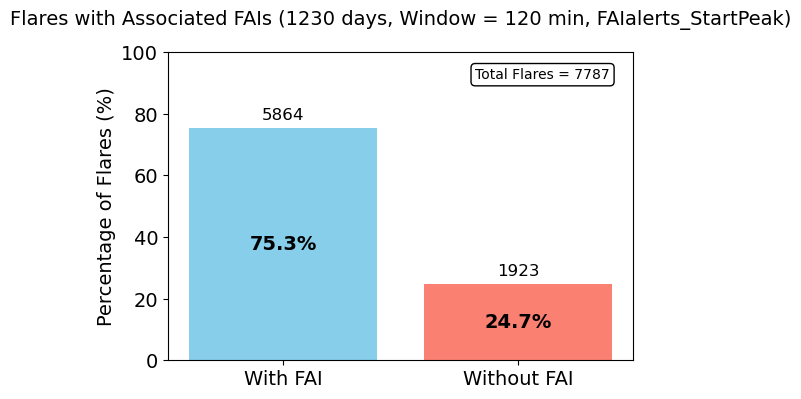

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window120min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5864 (75.3%)
Flares sin FAI: 1923 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_120min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


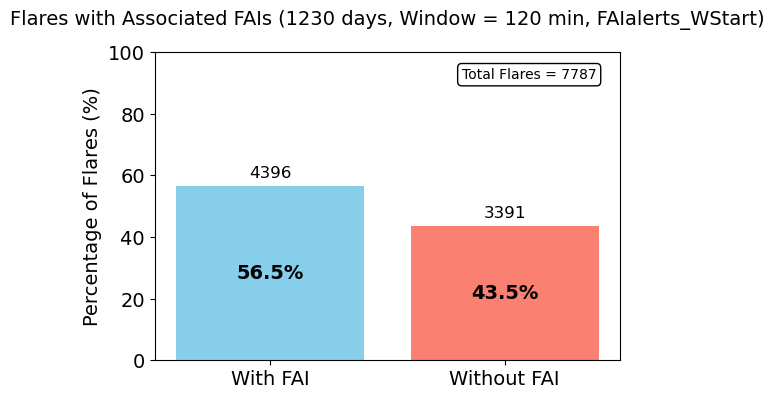

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window120min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4396 (56.5%)
Flares sin FAI: 3391 (43.5%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_120min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


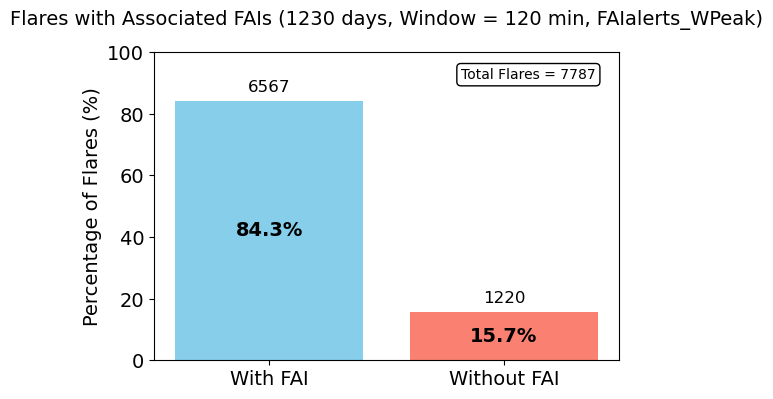

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window120min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6567 (84.3%)
Flares sin FAI: 1220 (15.7%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_120min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


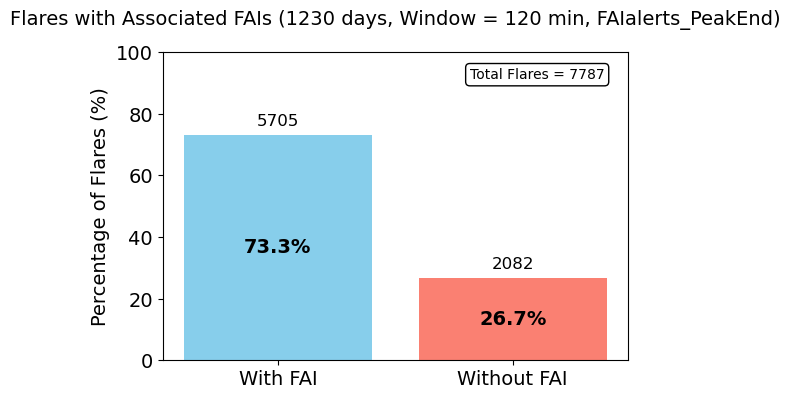

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window120min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_120min.png

📊 Procesando: df_anticipation_65min.csv (ventana: 65 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


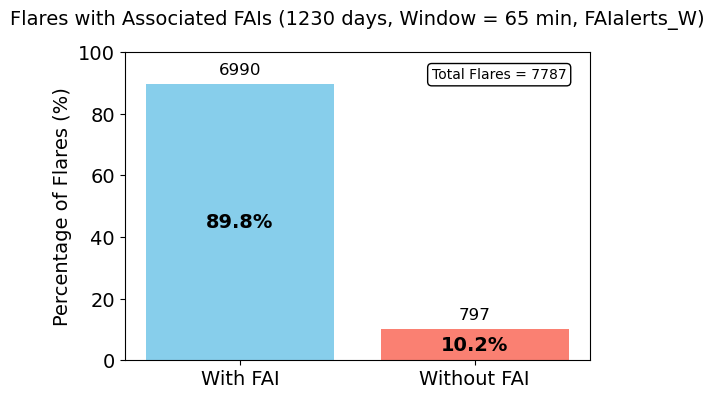

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window65min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6990 (89.8%)
Flares sin FAI: 797 (10.2%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_65min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


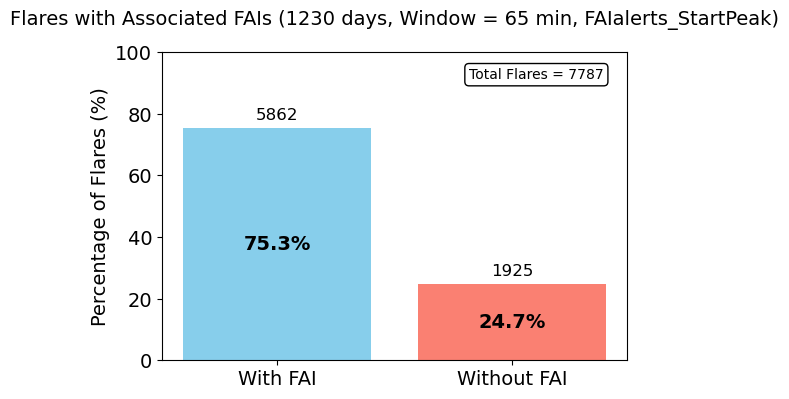

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window65min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5862 (75.3%)
Flares sin FAI: 1925 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_65min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


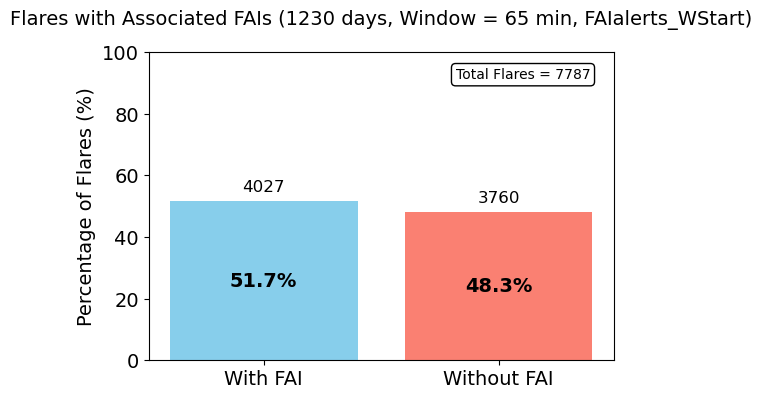

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window65min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4027 (51.7%)
Flares sin FAI: 3760 (48.3%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_65min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


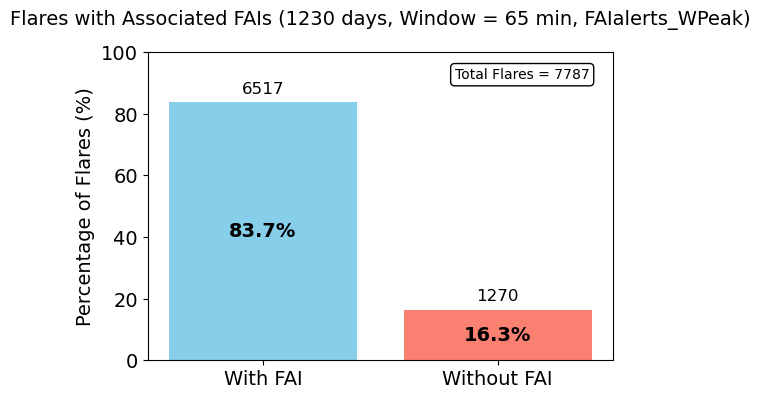

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window65min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6517 (83.7%)
Flares sin FAI: 1270 (16.3%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_65min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


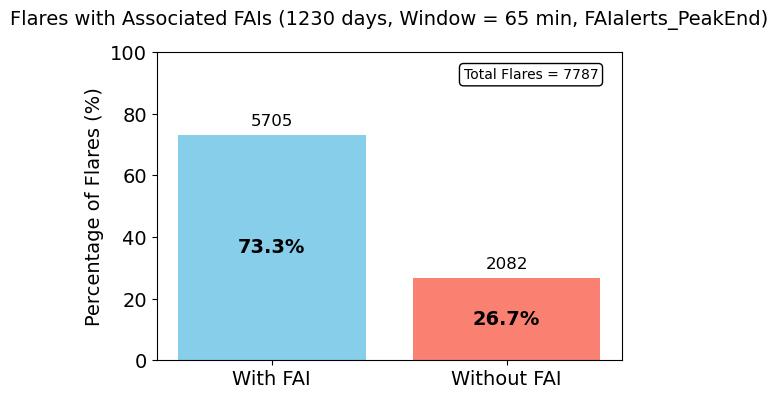

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window65min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_65min.png

📊 Procesando: df_anticipation_70min.csv (ventana: 70 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


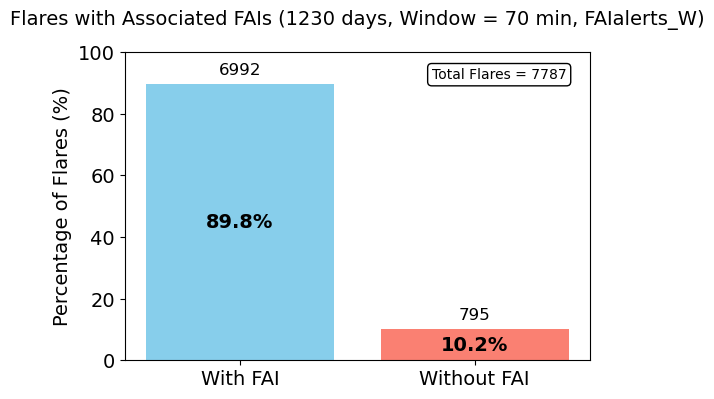

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window70min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6992 (89.8%)
Flares sin FAI: 795 (10.2%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_70min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


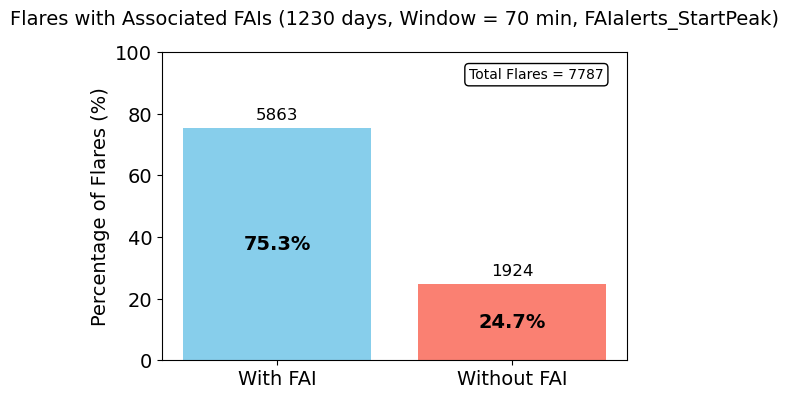

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window70min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_70min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


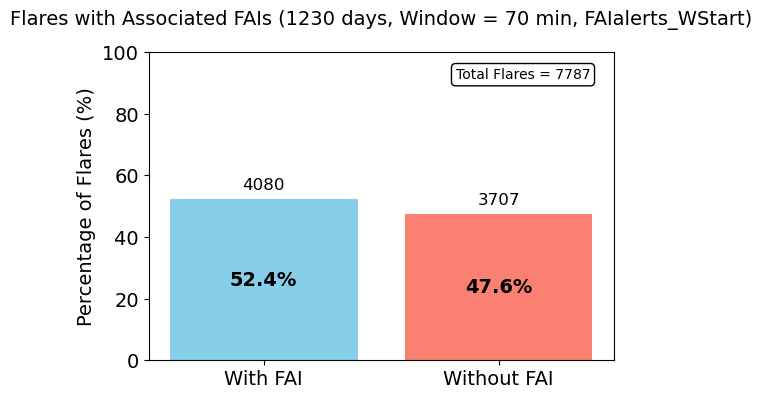

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window70min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4080 (52.4%)
Flares sin FAI: 3707 (47.6%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_70min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


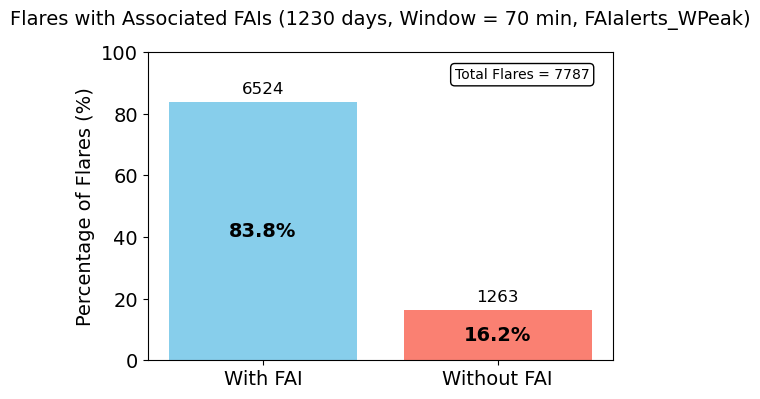

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window70min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6524 (83.8%)
Flares sin FAI: 1263 (16.2%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_70min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


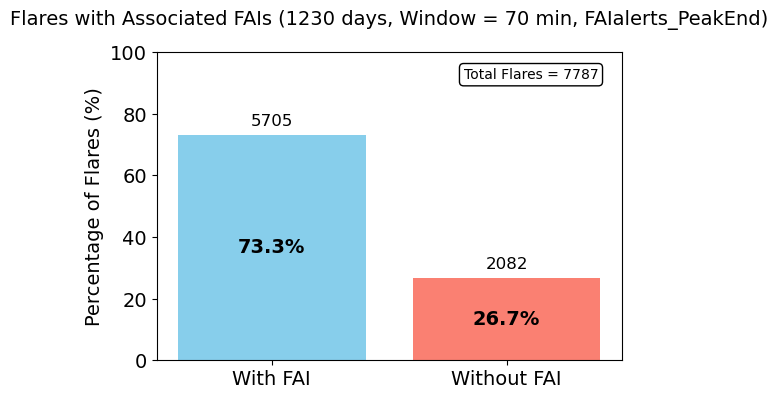

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window70min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_70min.png

📊 Procesando: df_anticipation_75min.csv (ventana: 75 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


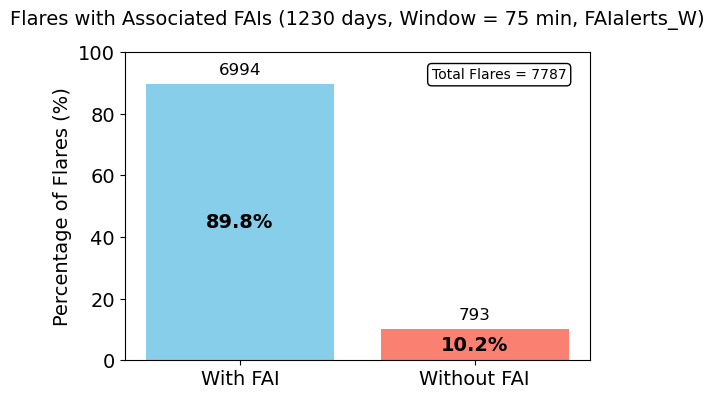

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window75min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6994 (89.8%)
Flares sin FAI: 793 (10.2%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_75min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


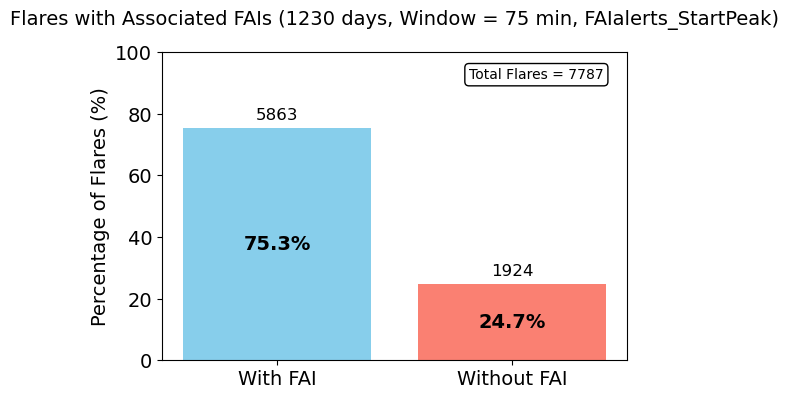

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window75min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_75min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


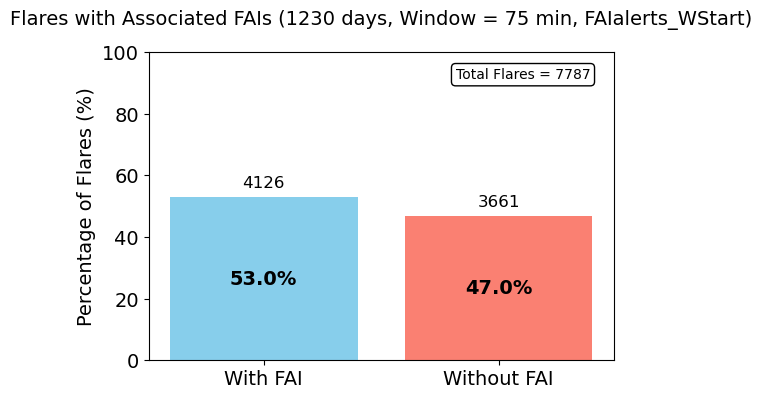

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window75min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4126 (53.0%)
Flares sin FAI: 3661 (47.0%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_75min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


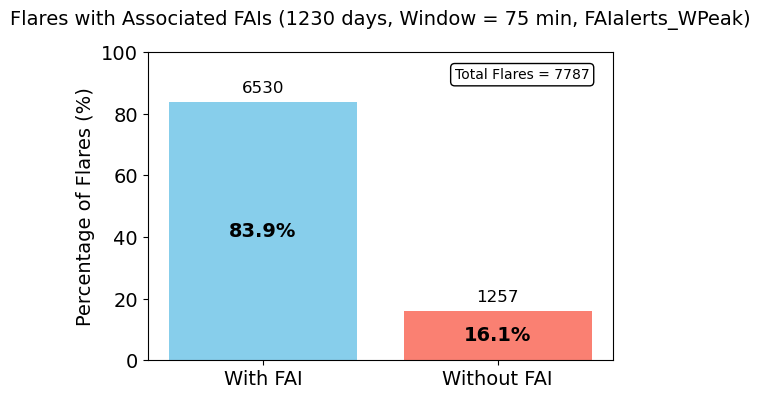

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window75min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6530 (83.9%)
Flares sin FAI: 1257 (16.1%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_75min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


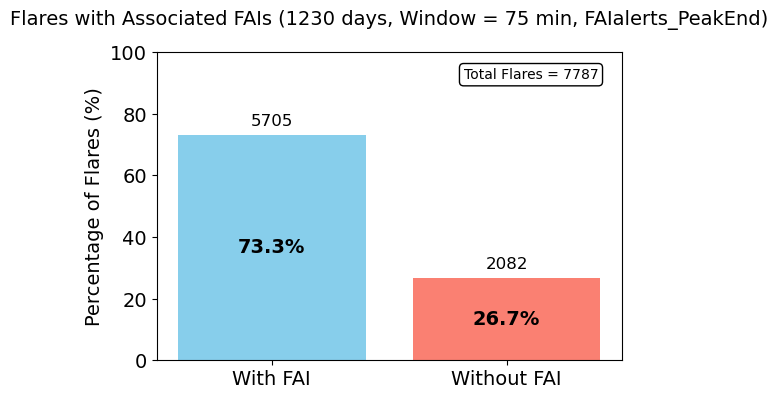

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window75min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_75min.png

📊 Procesando: df_anticipation_80min.csv (ventana: 80 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


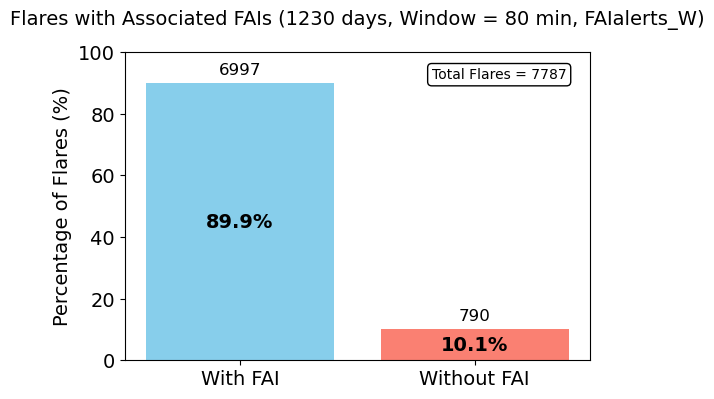

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window80min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6997 (89.9%)
Flares sin FAI: 790 (10.1%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_80min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


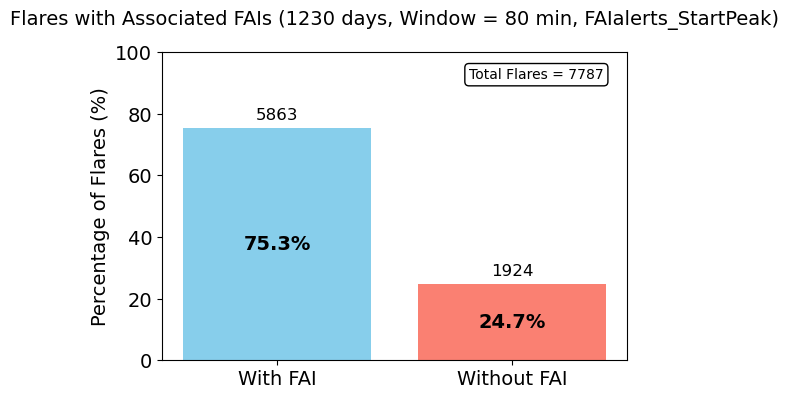

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window80min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_80min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


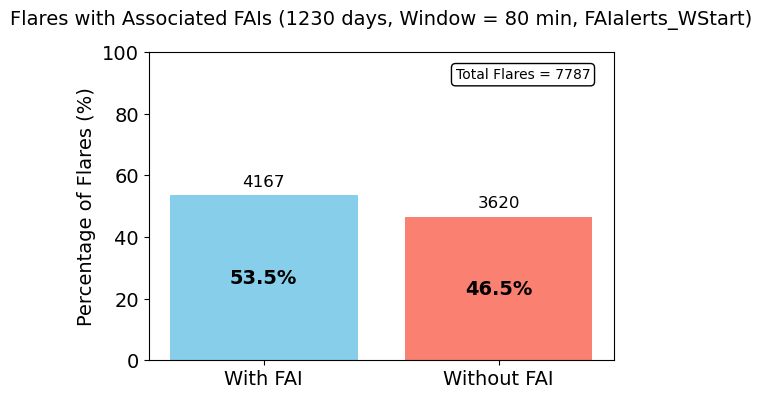

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window80min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4167 (53.5%)
Flares sin FAI: 3620 (46.5%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_80min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


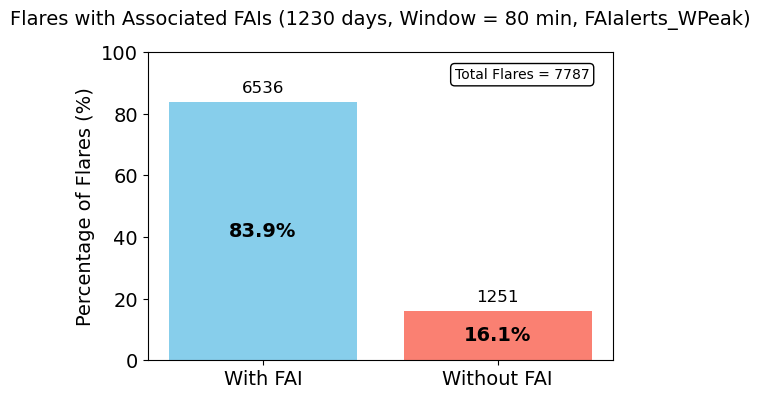

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window80min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6536 (83.9%)
Flares sin FAI: 1251 (16.1%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_80min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


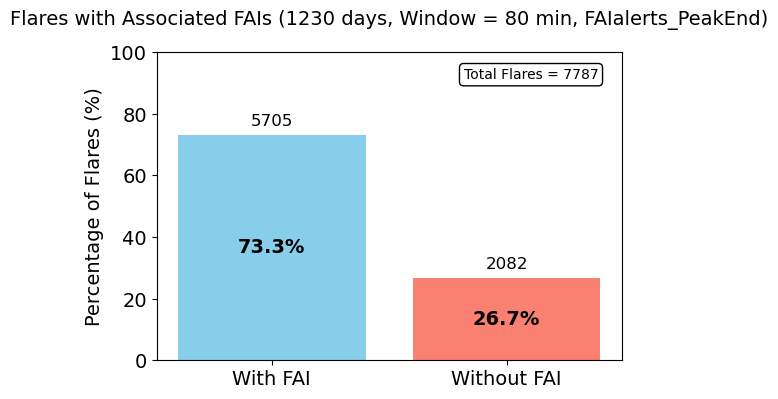

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window80min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_80min.png

📊 Procesando: df_anticipation_85min.csv (ventana: 85 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


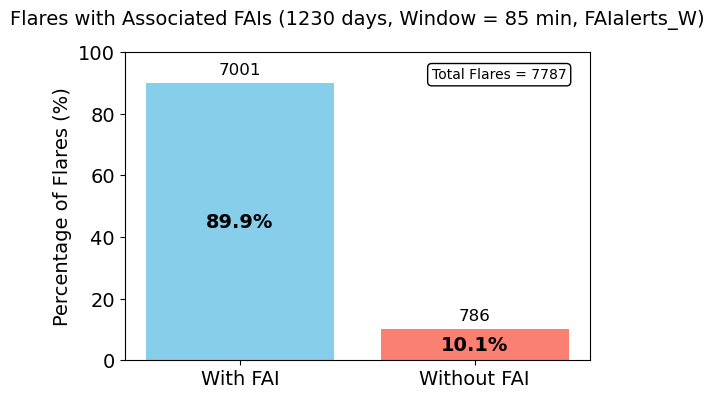

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window85min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7001 (89.9%)
Flares sin FAI: 786 (10.1%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_85min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


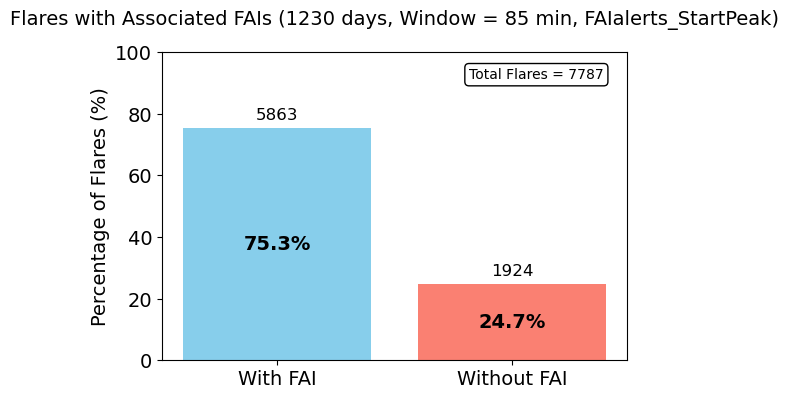

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window85min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_85min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


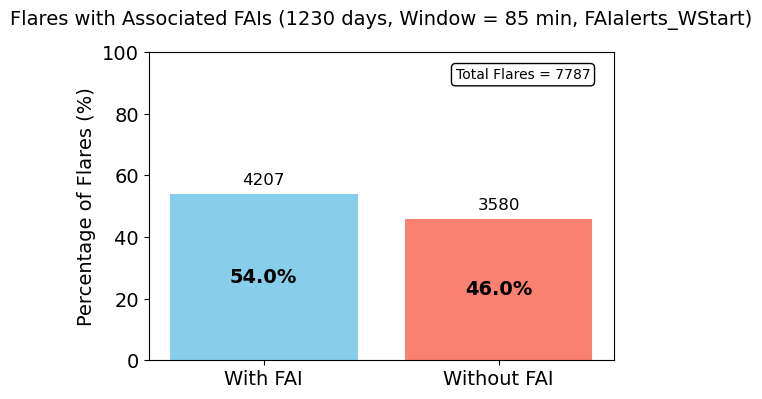

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window85min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4207 (54.0%)
Flares sin FAI: 3580 (46.0%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_85min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


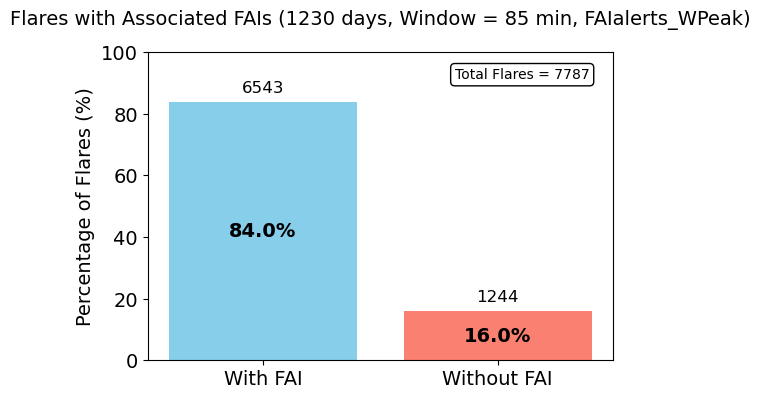

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window85min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6543 (84.0%)
Flares sin FAI: 1244 (16.0%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_85min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


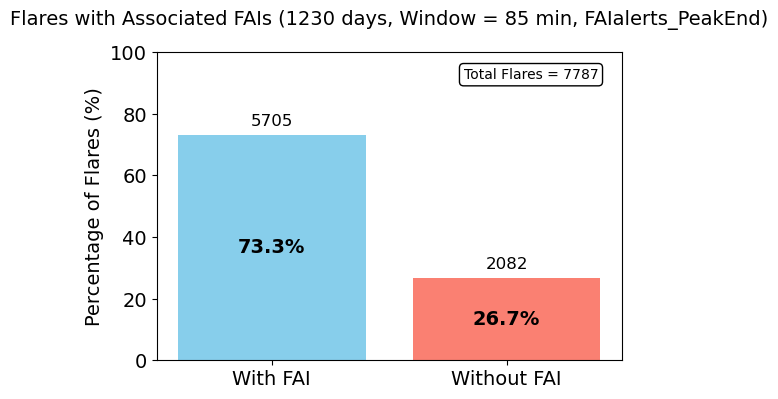

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window85min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_85min.png

📊 Procesando: df_anticipation_90min.csv (ventana: 90 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


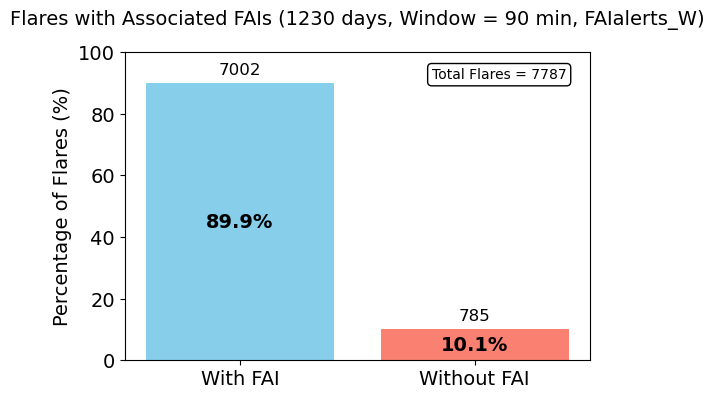

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window90min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7002 (89.9%)
Flares sin FAI: 785 (10.1%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_90min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


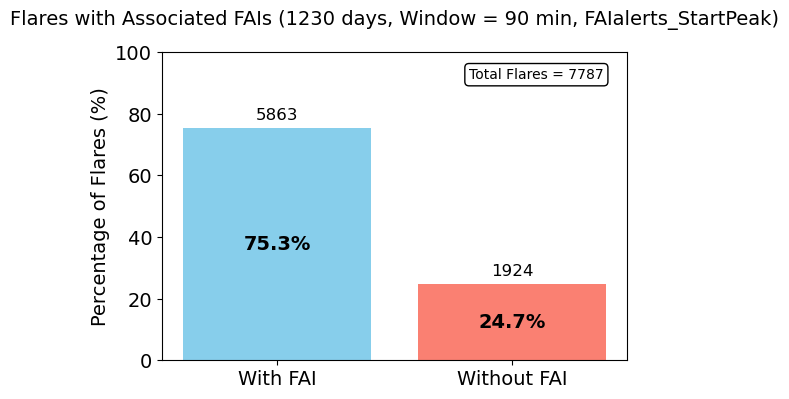

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window90min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_90min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


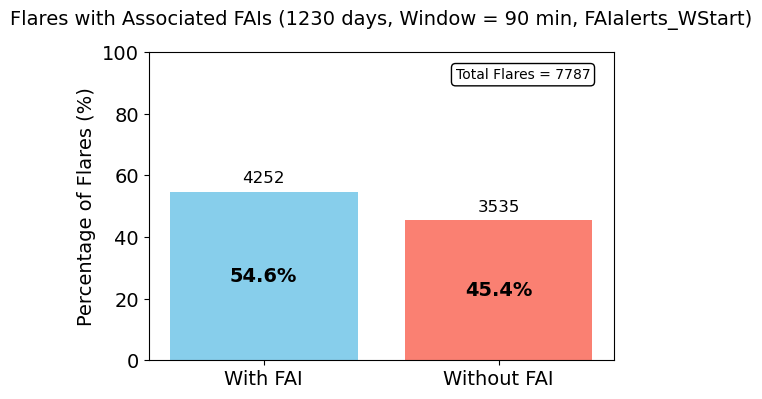

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window90min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4252 (54.6%)
Flares sin FAI: 3535 (45.4%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_90min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


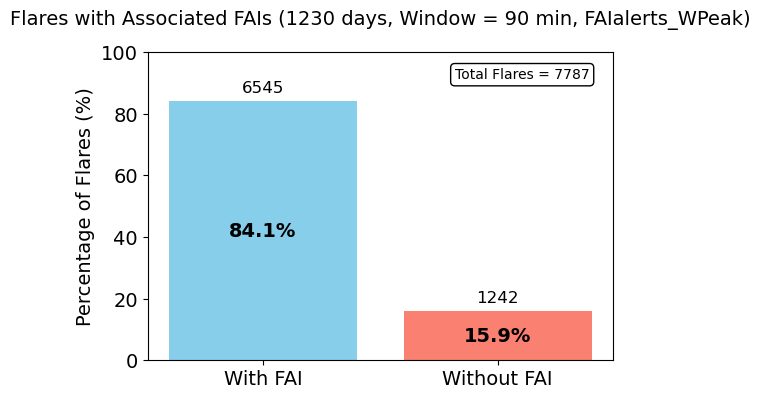

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window90min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6545 (84.1%)
Flares sin FAI: 1242 (15.9%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_90min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


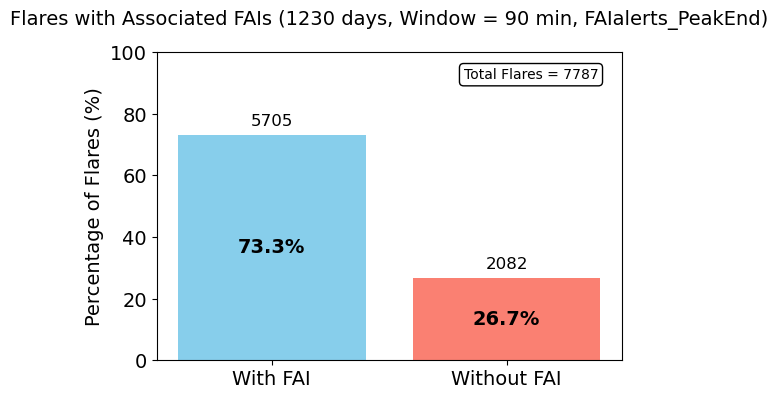

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window90min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_90min.png

📊 Procesando: df_anticipation_95min.csv (ventana: 95 min)
   📋 Columnas disponibles: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'Peak_to_lastFAI']
   📊 Generando gráfica para FAIalerts_W...
Usando columna FAI: FAIalerts_W


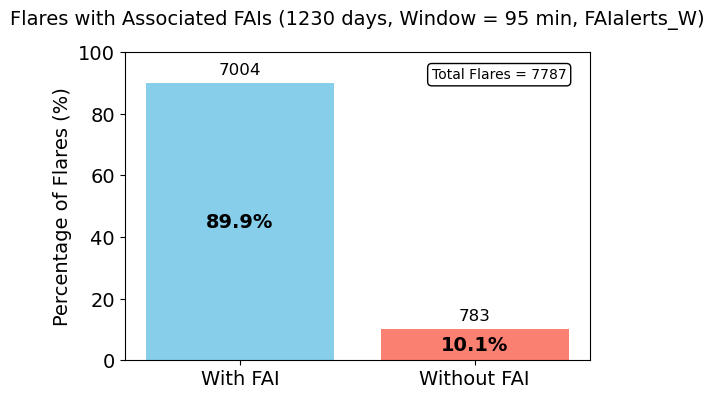

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window95min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 7004 (89.9%)
Flares sin FAI: 783 (10.1%)
Columna FAI utilizada: FAIalerts_W
   ✅ Gráfica FAIalerts_W guardada: Flares_associated_FAIalerts_W_95min.png
   📊 Generando gráfica para FAIalerts_StartPeak...
Usando columna FAI: FAIalerts_StartPeak


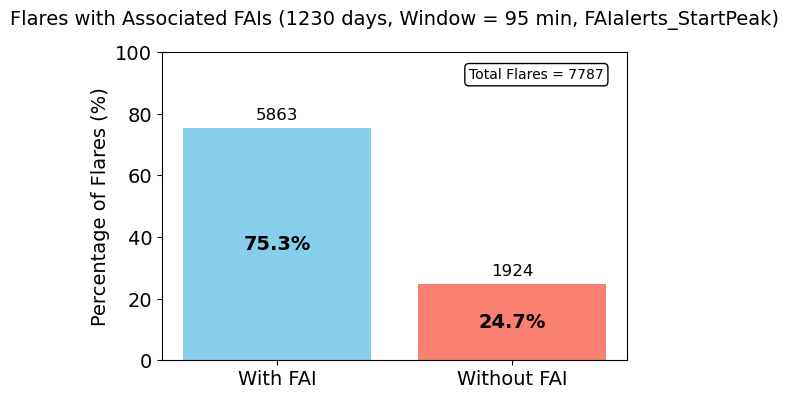

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window95min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5863 (75.3%)
Flares sin FAI: 1924 (24.7%)
Columna FAI utilizada: FAIalerts_StartPeak
   ✅ Gráfica FAIalerts_StartPeak guardada: Flares_associated_FAIalerts_StartPeak_95min.png
   📊 Generando gráfica para FAIalerts_WStart...
Usando columna FAI: FAIalerts_WStart


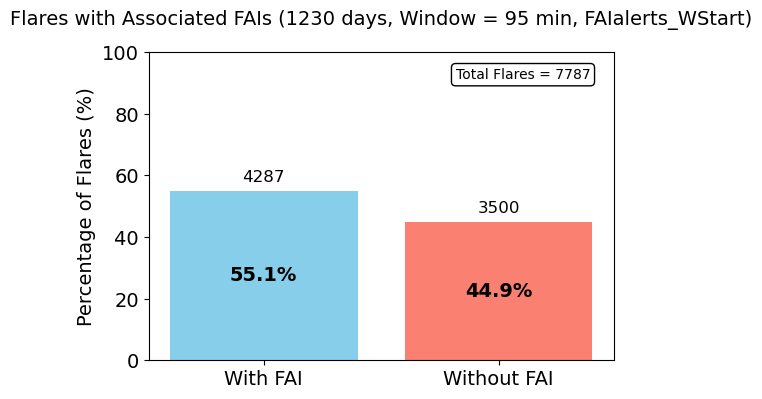

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window95min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 4287 (55.1%)
Flares sin FAI: 3500 (44.9%)
Columna FAI utilizada: FAIalerts_WStart
   ✅ Gráfica FAIalerts_WStart guardada: Flares_associated_FAIalerts_WStart_95min.png
   📊 Generando gráfica para FAIalerts_WPeak...
Usando columna FAI: FAIalerts_WPeak


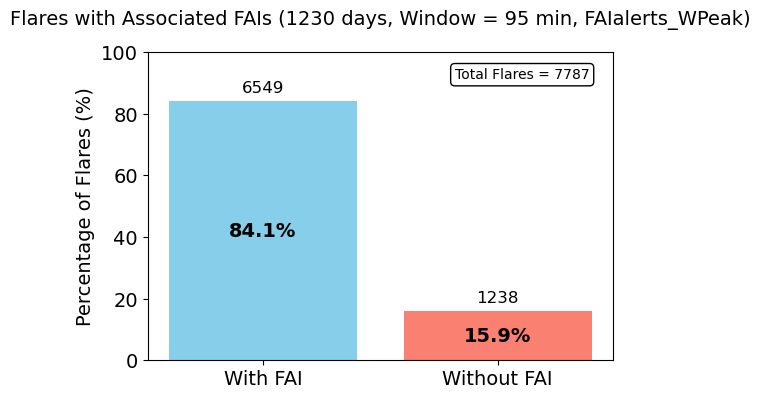

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window95min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 6549 (84.1%)
Flares sin FAI: 1238 (15.9%)
Columna FAI utilizada: FAIalerts_WPeak
   ✅ Gráfica FAIalerts_WPeak guardada: Flares_associated_FAIalerts_WPeak_95min.png
   📊 Generando gráfica para FAIalerts_PeakEnd...
Usando columna FAI: FAIalerts_PeakEnd


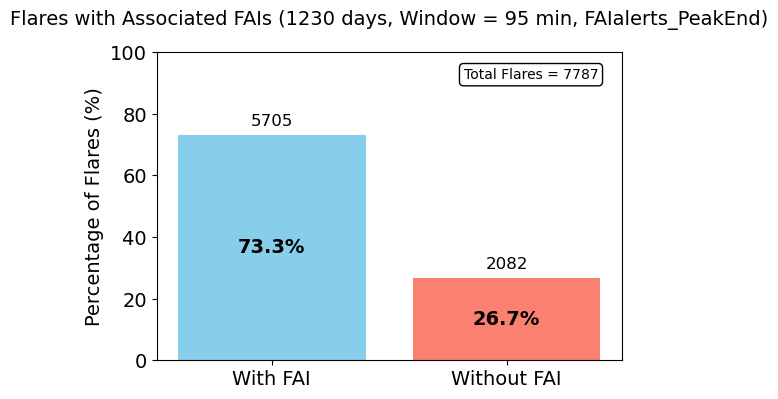

se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Flares_with_FAIs_perc_Window95min.png

--- Estadísticas FAI ---
Total flares analizados: 7787
Flares con FAI: 5705 (73.3%)
Flares sin FAI: 2082 (26.7%)
Columna FAI utilizada: FAIalerts_PeakEnd
   ✅ Gráfica FAIalerts_PeakEnd guardada: Flares_associated_FAIalerts_PeakEnd_95min.png

🎯 Todas las gráficas de asociación guardadas en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/Flares_asociatad_fai_plots


In [218]:
association_results_dir = plot_fai_association_for_all_windows(
    base_dir=anticipation_dir,
    n_days=n_days,
    fai_columns=['FAIalerts_W', 'FAIalerts_StartPeak', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_PeakEnd']  # Puedes ajustar estas columnas
)

### FAI distribution

In [219]:
def plot_fai_distribution(df_fai_assoc, n_days, window_minutes,
                         class_col="Flare_Class",
                         assoc_col="Associated_Flare",
                         group_subclasses=False,
                         color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages:
    - Fraction of FAIs associated with each flare class (or subrange if group_subclasses=True)
    - Fraction not associated with any flare ("No flare")
    
    Parameters:
    - df_fai_assoc: DataFrame with at least columns `class_col` and `assoc_col`
    - n_days: number of days analyzed (for title)
    - window_minutes: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = df_fai_assoc.copy()

    # Verificar que las columnas necesarias existen
    if class_col not in df.columns or assoc_col not in df.columns:
        available_cols = df.columns.tolist()
        raise ValueError(f"DataFrame must contain '{class_col}' and '{assoc_col}'. Available columns: {available_cols}")

    print(f"Usando columnas: {class_col} para clases y {assoc_col} para asociación")
    print(f"Total FAIs en análisis: {len(df)}")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]

    # Etiquetar FAIs no asociados
    df["AssocGroup"] = df.apply(
        lambda row: row["ClassGroup"] if row[assoc_col] else "No flare", axis=1
    )

    # Contar distribución
    counts = df["AssocGroup"].value_counts()

    # Ordenar clases: primero A, B, C, M, X o sus subrangos, luego "No flare"
    if group_subclasses:
        flare_classes = sorted([c for c in counts.index if c != "No flare"])
    else:
        flare_classes_order = ["A", "B", "C", "M", "X"]
        flare_classes = [cls for cls in flare_classes_order if cls in counts.index]

    if "No flare" in counts.index:
        flare_classes.append("No flare")

    counts_ordered = counts[flare_classes]
    percentages = (counts_ordered / counts_ordered.sum()) * 100

    classes = percentages.index.tolist()
    values = percentages.tolist()
    n_bars = len(classes)

    print(f"Distribución encontrada: {dict(zip(classes, counts_ordered))}")

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato",
                       "No flare": "lightgray"}
        colors = [base_colors.get(str(c)[0], base_colors.get(c, "gray")) for c in classes]
    else:
        colors = "skyblue"

    # --- Layout con leyenda abajo ---
    chart_width = max(8, n_bars * 1.3)
    chart_height = 6.7

    fontsize = 10
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    # --- Subplots ---
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 15,
        "legend.fontsize": 14
    })

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=1.0) # espacio entre gráfico y leyenda
    
    # --- Gráfico de barras ---
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_ylim(0, 100)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("FAIs (% of total)")
    ax.set_xlabel("Flare Class (or No flare)")
    ax.set_title(f"Distribution of FAIs: Associated vs Not Associated\n({n_days} days, Window = {window_minutes} min)",
                 pad=20) # espacio entre título y gráfico

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=14, fontweight='bold')

    # --- Leyenda abajo ---
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts_ordered[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title_fontsize=16, # tamaño titulo leyenda
                  title="Number of FAIs per group:")

    output_name = f"{n_days}d_Distribution_FAIs_All_Window{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"grafica extraña se guardo en: {output_path}")
    
    # Estadísticas adicionales
    total_fais = len(df)
    associated_fais = df[assoc_col].sum()
    not_associated_fais = total_fais - associated_fais
    
    print(f"\n--- Estadísticas de Distribución FAI ---")
    print(f"Total FAIs: {total_fais}")
    print(f"FAIs asociados a flares: {associated_fais} ({associated_fais/total_fais*100:.1f}%)")
    print(f"FAIs no asociados: {not_associated_fais} ({not_associated_fais/total_fais*100:.1f}%)")
    
    if associated_fais > 0:
        print(f"\nDistribución de FAIs asociados por clase:")
        associated_by_class = df[df[assoc_col]]['ClassGroup'].value_counts()
        for cls, count in associated_by_class.items():
            percentage = (count / associated_fais) * 100
            print(f"  {cls}: {count} FAIs ({percentage:.1f}%)")



In [220]:
def plot_fai_distribution_for_all_windows(base_dir, n_days):
    """
    Ejecuta plot_fai_distribution para todos los archivos df_fai_assoc_*min.csv
    en el directorio especificado.
    """
    # Patrón para encontrar los archivos
    pattern = os.path.join(base_dir, "df_fai_assoc_*min.csv")
    csv_files = glob.glob(pattern)
    
    if not csv_files:
        print(f"❌ No se encontraron archivos df_fai_assoc en: {base_dir}")
        print(f"   Patrón usado: {pattern}")
        return
    
    print(f"📁 Encontrados {len(csv_files)} archivos df_fai_assoc en: {base_dir}")
    
    # Crear directorio para gráficas de distribución
    distribution_graphics_dir = os.path.join(graphics_dir, "fai_distribution_plots")
    os.makedirs(distribution_graphics_dir, exist_ok=True)
    
    for csv_file in sorted(csv_files):
        try:
            # Extraer window_minutes del nombre del archivo
            filename = os.path.basename(csv_file)
            # El formato es: df_fai_assoc_30min.csv
            window_minutes = int(filename.split('_')[3].replace('min.csv', ''))
            
            print(f"\n📊 Procesando: {filename} (ventana: {window_minutes} min)")
            
            # Leer el archivo
            df_fai_assoc = pd.read_csv(csv_file)
            
            print(f"   📋 Columnas disponibles: {df_fai_assoc.columns.tolist()}")
            
            # Verificar que tenemos las columnas necesarias
            if "Flare_Class" not in df_fai_assoc.columns:
                print(f"   ⚠️  Columna 'Flare_Class' no encontrada. Saltando...")
                continue
                
            if "Associated_Flare" not in df_fai_assoc.columns:
                print(f"   ⚠️  Columna 'Associated_Flare' no encontrada. Saltando...")
                continue
            
            print(f"   🔍 Usando columnas: Flare_Class y Associated_Flare")
            
            # Ejecutar plot_fai_distribution EXACTAMENTE como la quieres
            plot_fai_distribution(
                df_fai_assoc=df_fai_assoc,
                n_days=n_days,
                window_minutes=window_minutes,
                class_col="Flare_Class",
                assoc_col="Associated_Flare",
                group_subclasses=True,
                color_mode="palette:viridis"
            )
            
            # Mover y renombrar la gráfica
            original_plot = f"{n_days}d_Distribution_FAIs_All_Window{window_minutes}min_SubClassTrue.png"
            new_plot = f"distribution_{window_minutes}min_subclassTrue.png"
            original_path = os.path.join(graphics_dir, original_plot)
            new_path = os.path.join(distribution_graphics_dir, new_plot)
            
            if os.path.exists(original_path):
                os.rename(original_path, new_path)
                print(f"   ✅ Gráfica correcta distribución guardada: {new_path}")
            else:
                # Intentar con nombre alternativo por si group_subclasses es False
                alt_plot = f"{n_days}d_Distribution_FAIs_All_Window{window_minutes}min_SubClassFalse.png"
                alt_path = os.path.join(graphics_dir, alt_plot)
                if os.path.exists(alt_path):
                    os.rename(alt_path, new_path)
                    print(f"   ✅ Gráfica distribución guardada (alternativa): {new_path}")
                else:
                    print(f"   ❌ No se encontró la gráfica: {original_plot}")
                    
        except Exception as e:
            print(f"   ❌ Error procesando {csv_file}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n🎯 Todas las gráficas de distribución guardadas en: {distribution_graphics_dir}")
    return distribution_graphics_dir



📁 Encontrados 12 archivos df_fai_assoc en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/association_analysis_65to120_step5

📊 Procesando: df_fai_assoc_100min.csv (ventana: 100 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Flare', 'Flare_StartTime', 'Flare_EndTime', 'Flare_PeakTime', 'Flare_Class', 'Time_to_flare', 'Flare_Observatory']
   🔍 Usando columnas: Flare_Class y Associated_Flare
Usando columnas: Flare_Class para clases y Associated_Flare para asociación
Total FAIs en análisis: 118189
Distribución encontrada: {'B1-4.9': 2465, 'B5-9.9': 5090, 'C1-4.9': 40526, 'C5-9.9': 15103, 'M1-4.9': 10619, 'M5-9.9': 1189, 'X1-4.9': 2672, 'X5+': 245, 'No flare': 40280}


/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


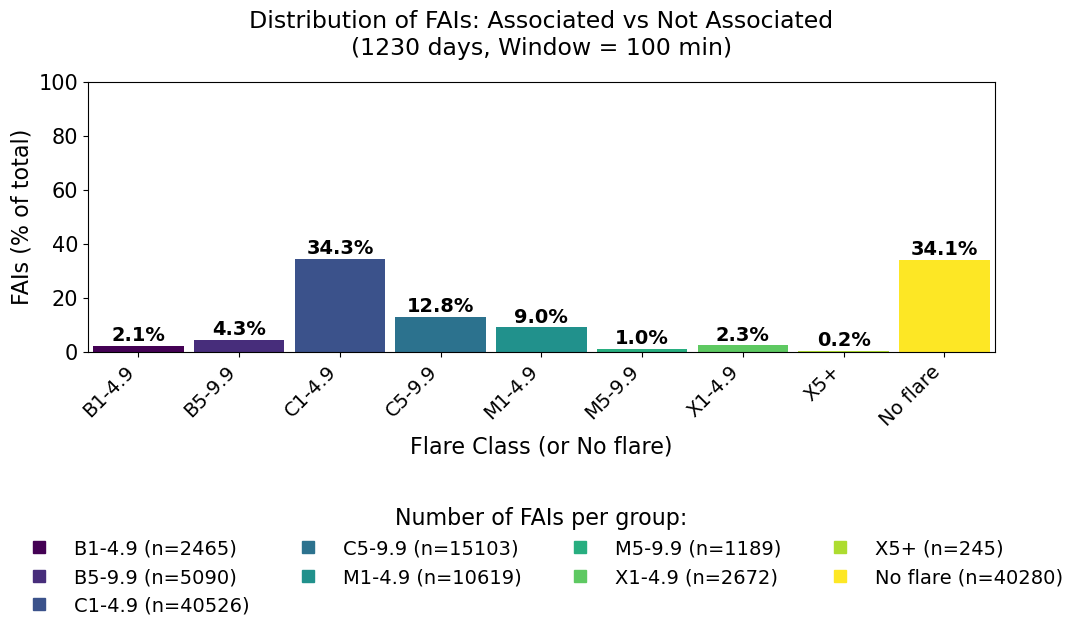

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window100min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 77909 (65.9%)
FAIs no asociados: 40280 (34.1%)

Distribución de FAIs asociados por clase:
  C1-4.9: 40526 FAIs (52.0%)
  C5-9.9: 15103 FAIs (19.4%)
  M1-4.9: 10619 FAIs (13.6%)
  B5-9.9: 5090 FAIs (6.5%)
  X1-4.9: 2672 FAIs (3.4%)
  B1-4.9: 2465 FAIs (3.2%)
  M5-9.9: 1189 FAIs (1.5%)
  X5+: 245 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_100min_subclassTrue.png

📊 Procesando: df_fai_assoc_105min.csv (ventana: 105 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


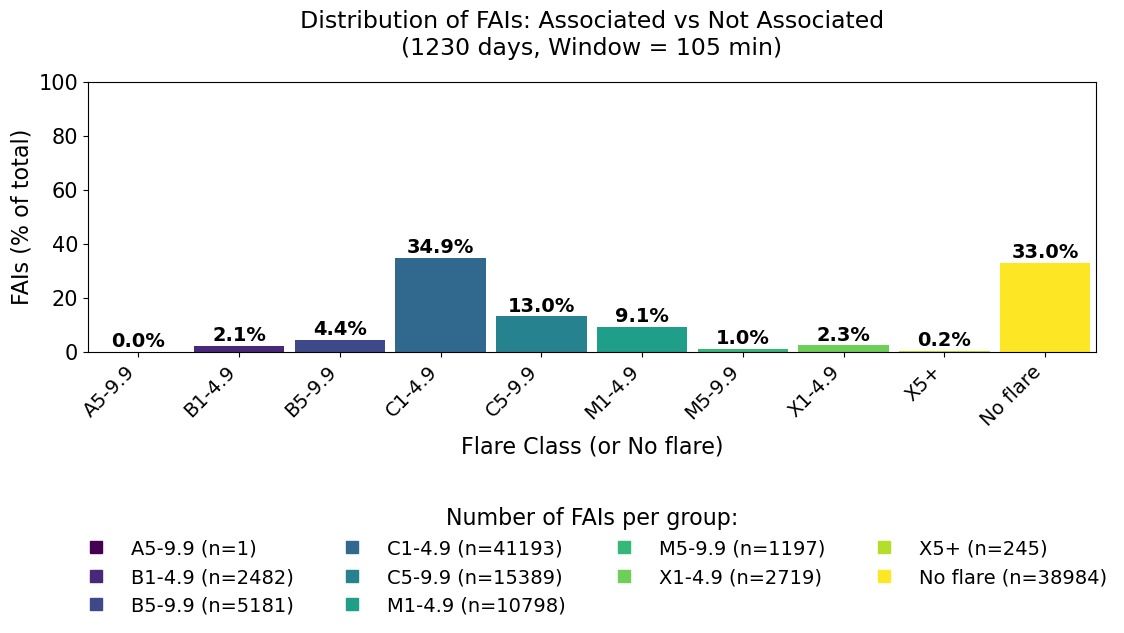

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window105min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 79205 (67.0%)
FAIs no asociados: 38984 (33.0%)

Distribución de FAIs asociados por clase:
  C1-4.9: 41193 FAIs (52.0%)
  C5-9.9: 15389 FAIs (19.4%)
  M1-4.9: 10798 FAIs (13.6%)
  B5-9.9: 5181 FAIs (6.5%)
  X1-4.9: 2719 FAIs (3.4%)
  B1-4.9: 2482 FAIs (3.1%)
  M5-9.9: 1197 FAIs (1.5%)
  X5+: 245 FAIs (0.3%)
  A5-9.9: 1 FAIs (0.0%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_105min_subclassTrue.png

📊 Procesando: df_fai_assoc_110min.csv (ventana: 110 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm',

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


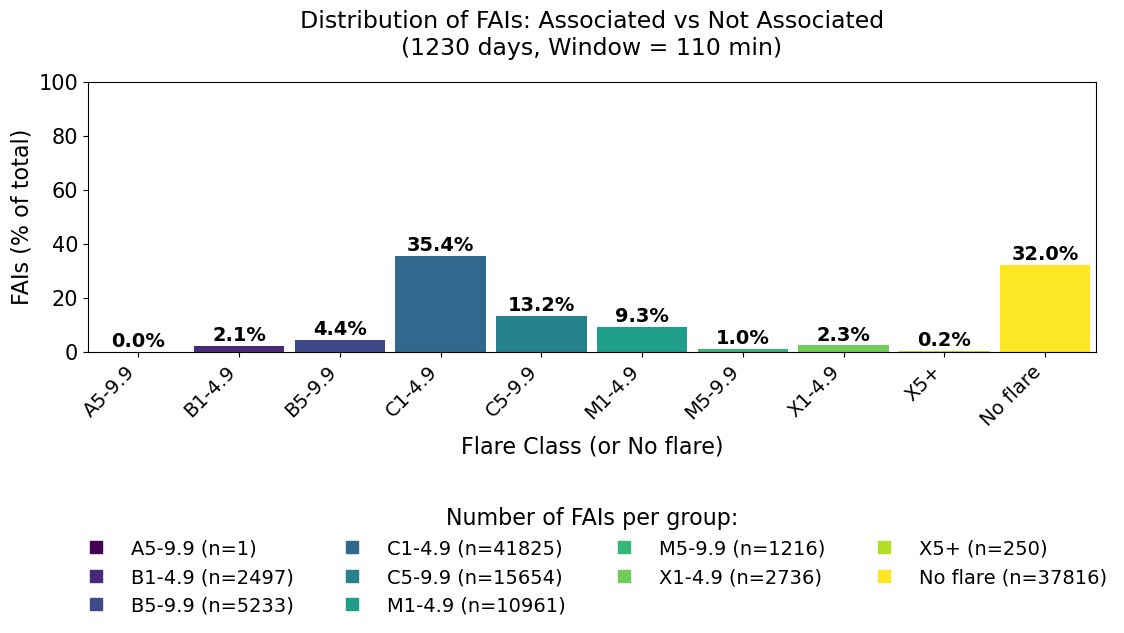

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window110min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 80373 (68.0%)
FAIs no asociados: 37816 (32.0%)

Distribución de FAIs asociados por clase:
  C1-4.9: 41825 FAIs (52.0%)
  C5-9.9: 15654 FAIs (19.5%)
  M1-4.9: 10961 FAIs (13.6%)
  B5-9.9: 5233 FAIs (6.5%)
  X1-4.9: 2736 FAIs (3.4%)
  B1-4.9: 2497 FAIs (3.1%)
  M5-9.9: 1216 FAIs (1.5%)
  X5+: 250 FAIs (0.3%)
  A5-9.9: 1 FAIs (0.0%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_110min_subclassTrue.png

📊 Procesando: df_fai_assoc_115min.csv (ventana: 115 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm',

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


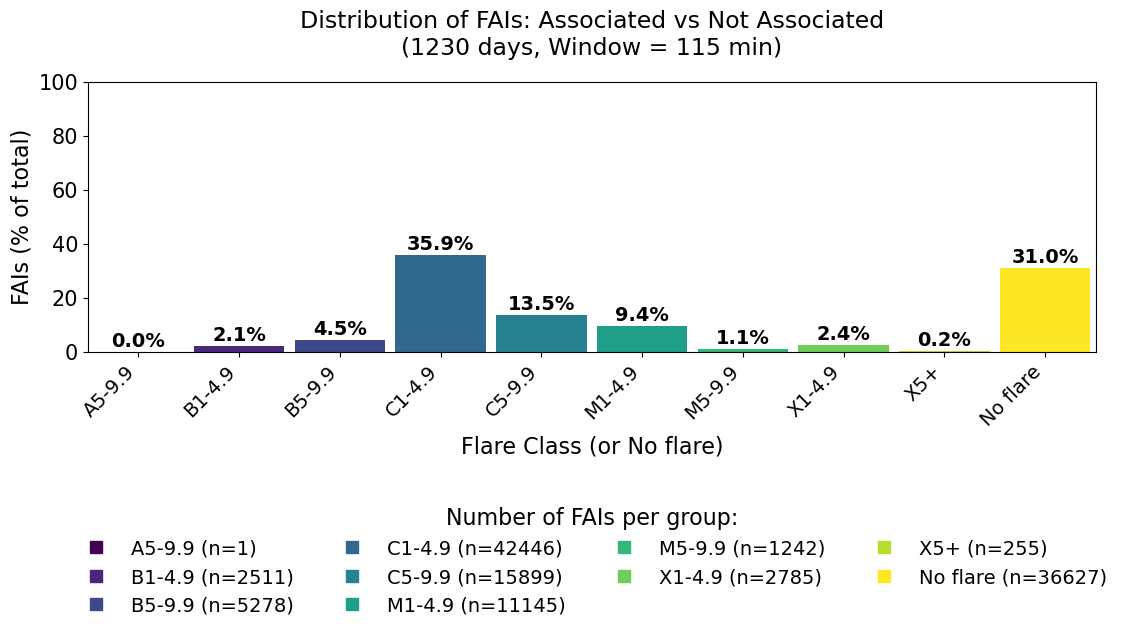

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window115min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 81562 (69.0%)
FAIs no asociados: 36627 (31.0%)

Distribución de FAIs asociados por clase:
  C1-4.9: 42446 FAIs (52.0%)
  C5-9.9: 15899 FAIs (19.5%)
  M1-4.9: 11145 FAIs (13.7%)
  B5-9.9: 5278 FAIs (6.5%)
  X1-4.9: 2785 FAIs (3.4%)
  B1-4.9: 2511 FAIs (3.1%)
  M5-9.9: 1242 FAIs (1.5%)
  X5+: 255 FAIs (0.3%)
  A5-9.9: 1 FAIs (0.0%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_115min_subclassTrue.png

📊 Procesando: df_fai_assoc_120min.csv (ventana: 120 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm',

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


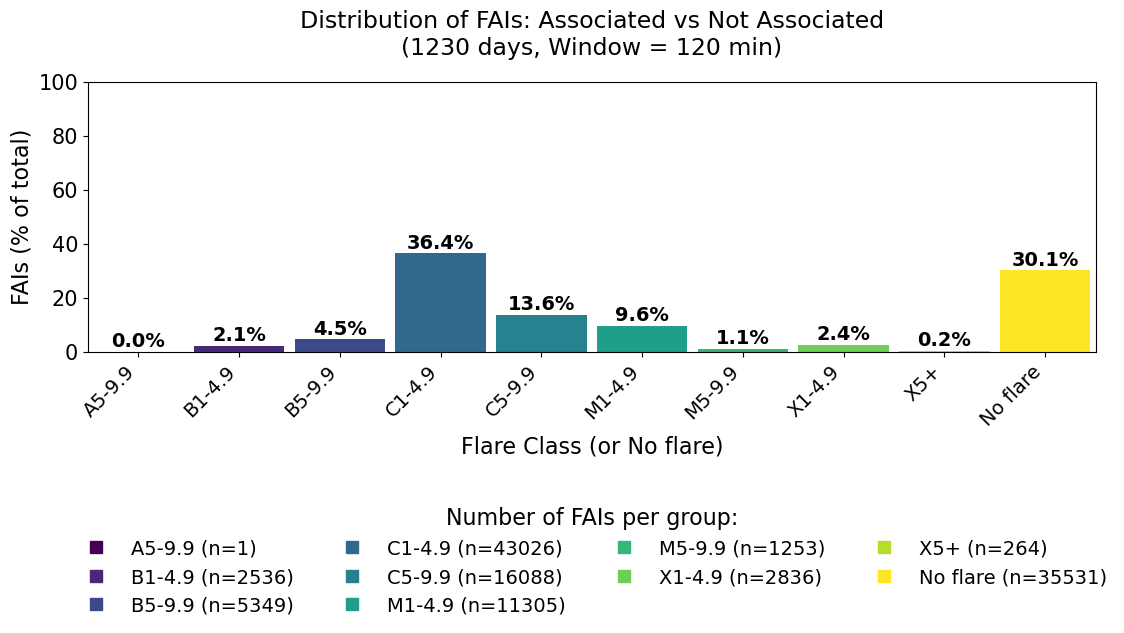

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window120min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 82658 (69.9%)
FAIs no asociados: 35531 (30.1%)

Distribución de FAIs asociados por clase:
  C1-4.9: 43026 FAIs (52.1%)
  C5-9.9: 16088 FAIs (19.5%)
  M1-4.9: 11305 FAIs (13.7%)
  B5-9.9: 5349 FAIs (6.5%)
  X1-4.9: 2836 FAIs (3.4%)
  B1-4.9: 2536 FAIs (3.1%)
  M5-9.9: 1253 FAIs (1.5%)
  X5+: 264 FAIs (0.3%)
  A5-9.9: 1 FAIs (0.0%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_120min_subclassTrue.png

📊 Procesando: df_fai_assoc_65min.csv (ventana: 65 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', '

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


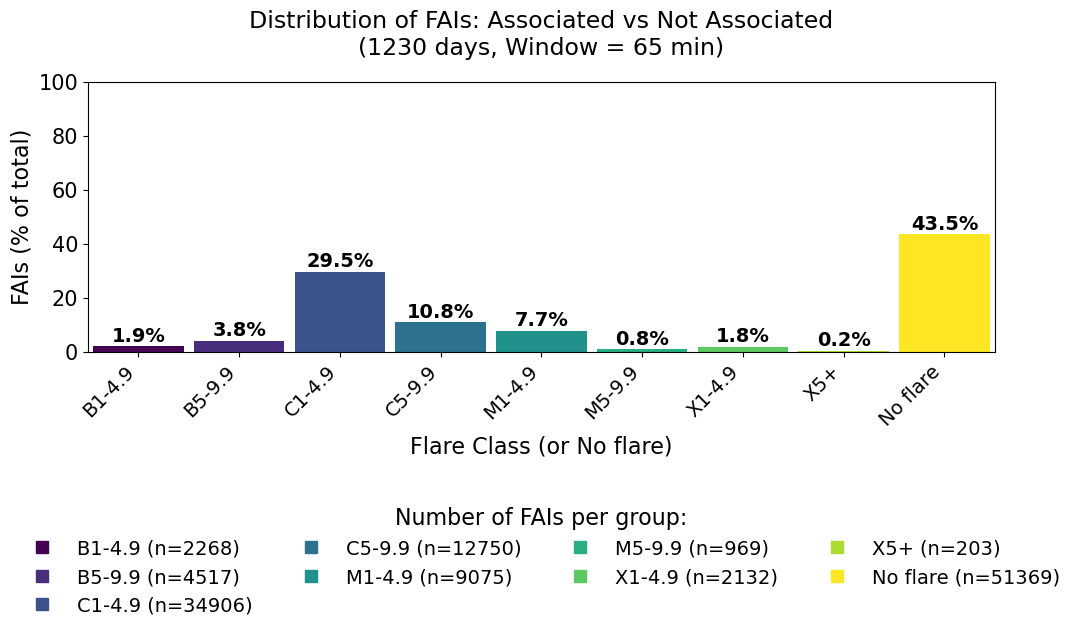

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window65min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 66820 (56.5%)
FAIs no asociados: 51369 (43.5%)

Distribución de FAIs asociados por clase:
  C1-4.9: 34906 FAIs (52.2%)
  C5-9.9: 12750 FAIs (19.1%)
  M1-4.9: 9075 FAIs (13.6%)
  B5-9.9: 4517 FAIs (6.8%)
  B1-4.9: 2268 FAIs (3.4%)
  X1-4.9: 2132 FAIs (3.2%)
  M5-9.9: 969 FAIs (1.5%)
  X5+: 203 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_65min_subclassTrue.png

📊 Procesando: df_fai_assoc_70min.csv (ventana: 70 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Flare

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


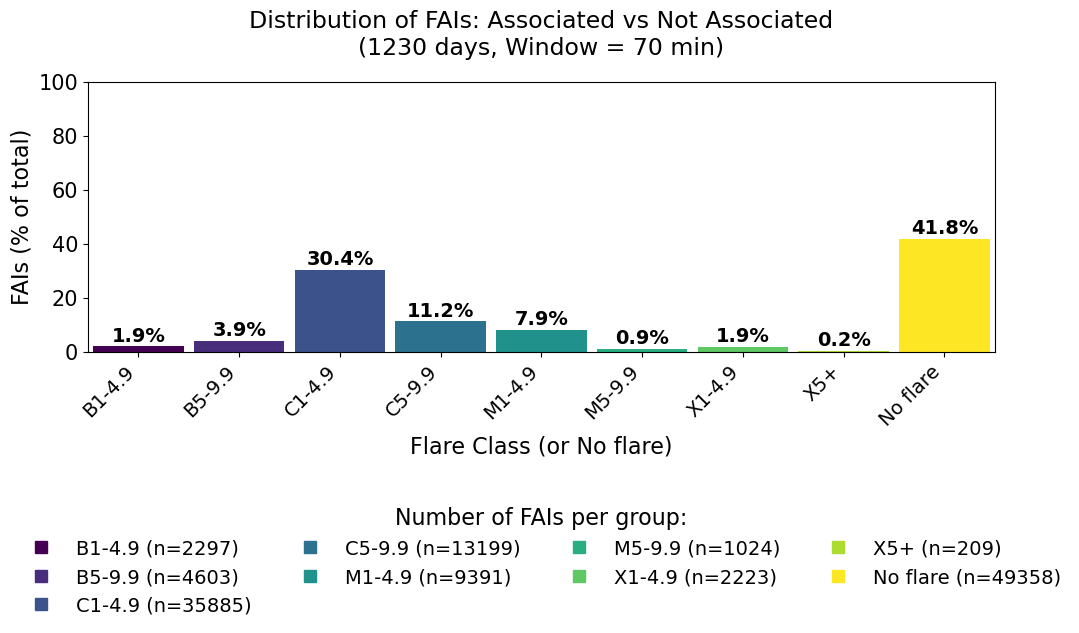

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window70min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 68831 (58.2%)
FAIs no asociados: 49358 (41.8%)

Distribución de FAIs asociados por clase:
  C1-4.9: 35885 FAIs (52.1%)
  C5-9.9: 13199 FAIs (19.2%)
  M1-4.9: 9391 FAIs (13.6%)
  B5-9.9: 4603 FAIs (6.7%)
  B1-4.9: 2297 FAIs (3.3%)
  X1-4.9: 2223 FAIs (3.2%)
  M5-9.9: 1024 FAIs (1.5%)
  X5+: 209 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_70min_subclassTrue.png

📊 Procesando: df_fai_assoc_75min.csv (ventana: 75 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Flar

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


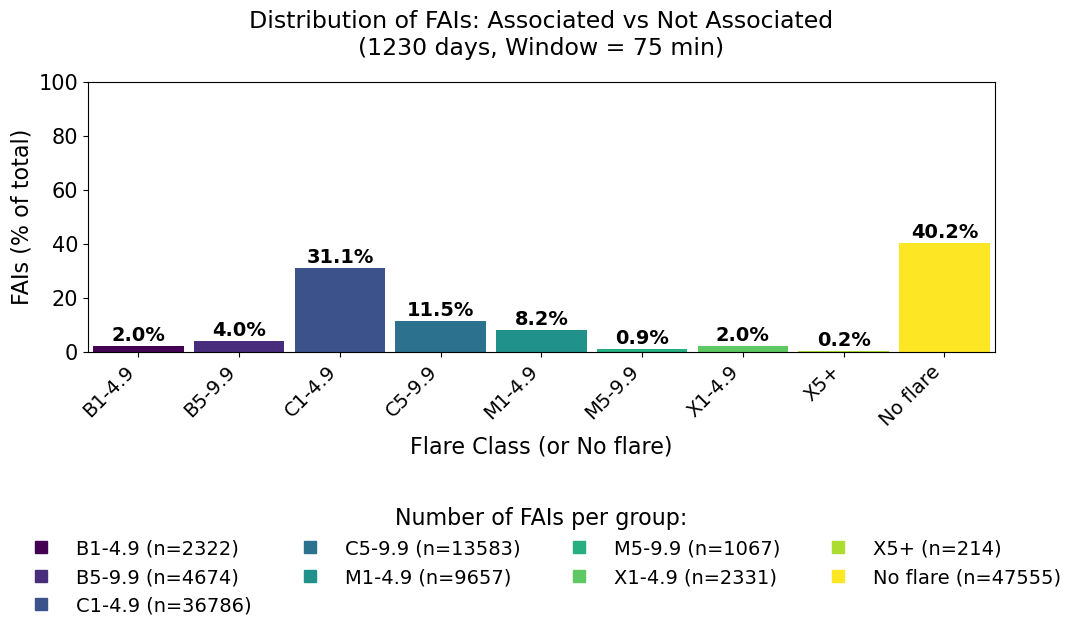

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window75min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 70634 (59.8%)
FAIs no asociados: 47555 (40.2%)

Distribución de FAIs asociados por clase:
  C1-4.9: 36786 FAIs (52.1%)
  C5-9.9: 13583 FAIs (19.2%)
  M1-4.9: 9657 FAIs (13.7%)
  B5-9.9: 4674 FAIs (6.6%)
  X1-4.9: 2331 FAIs (3.3%)
  B1-4.9: 2322 FAIs (3.3%)
  M5-9.9: 1067 FAIs (1.5%)
  X5+: 214 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_75min_subclassTrue.png

📊 Procesando: df_fai_assoc_80min.csv (ventana: 80 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Flar

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


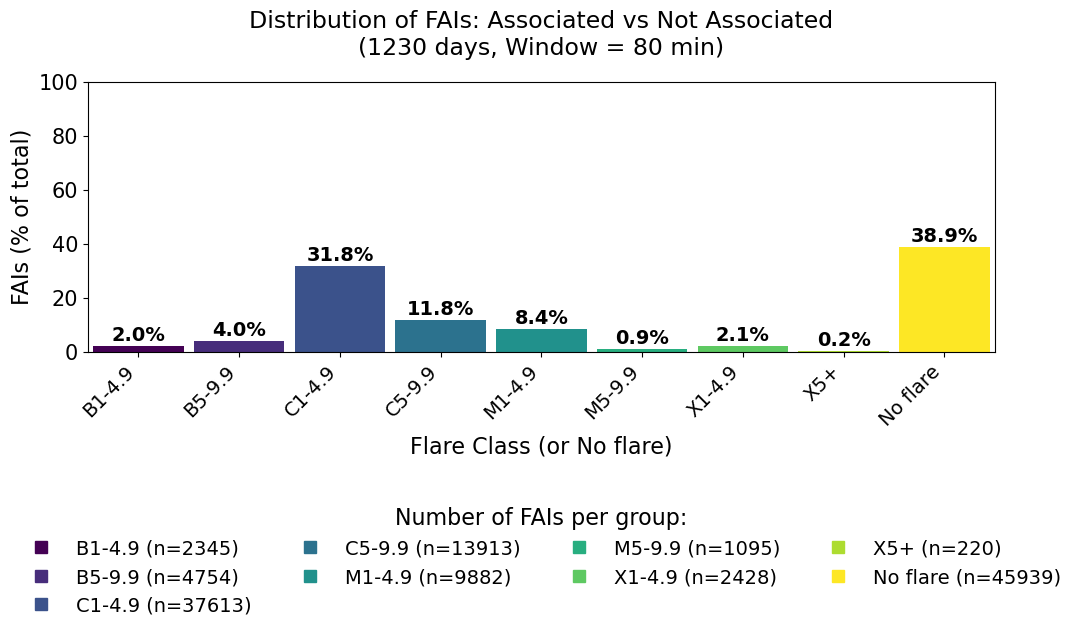

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window80min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 72250 (61.1%)
FAIs no asociados: 45939 (38.9%)

Distribución de FAIs asociados por clase:
  C1-4.9: 37613 FAIs (52.1%)
  C5-9.9: 13913 FAIs (19.3%)
  M1-4.9: 9882 FAIs (13.7%)
  B5-9.9: 4754 FAIs (6.6%)
  X1-4.9: 2428 FAIs (3.4%)
  B1-4.9: 2345 FAIs (3.2%)
  M5-9.9: 1095 FAIs (1.5%)
  X5+: 220 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_80min_subclassTrue.png

📊 Procesando: df_fai_assoc_85min.csv (ventana: 85 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Flar

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


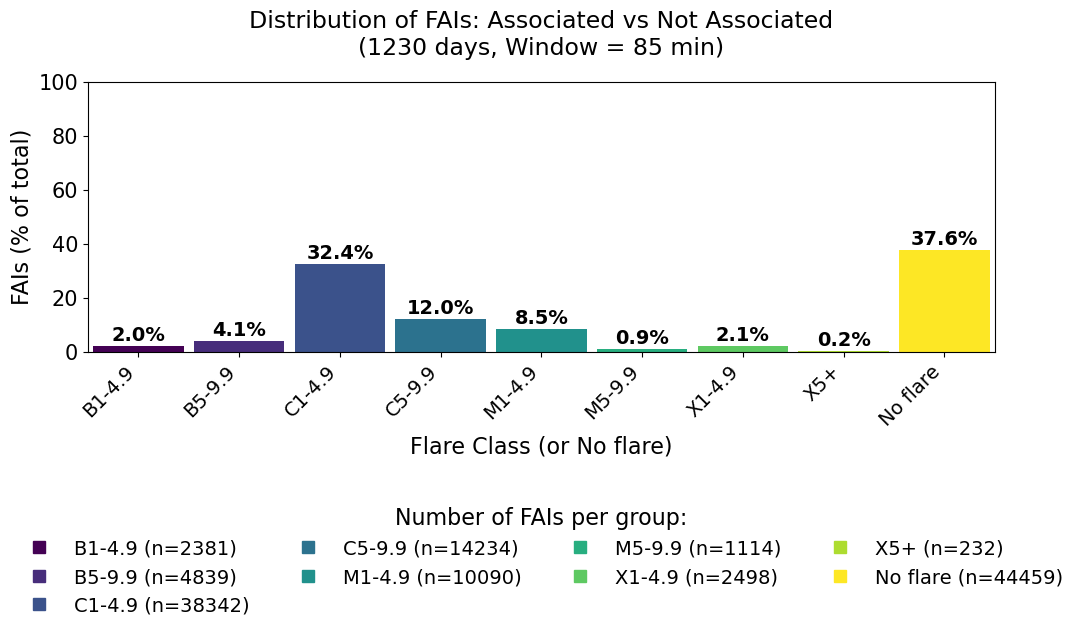

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window85min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 73730 (62.4%)
FAIs no asociados: 44459 (37.6%)

Distribución de FAIs asociados por clase:
  C1-4.9: 38342 FAIs (52.0%)
  C5-9.9: 14234 FAIs (19.3%)
  M1-4.9: 10090 FAIs (13.7%)
  B5-9.9: 4839 FAIs (6.6%)
  X1-4.9: 2498 FAIs (3.4%)
  B1-4.9: 2381 FAIs (3.2%)
  M5-9.9: 1114 FAIs (1.5%)
  X5+: 232 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_85min_subclassTrue.png

📊 Procesando: df_fai_assoc_90min.csv (ventana: 90 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Fla

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


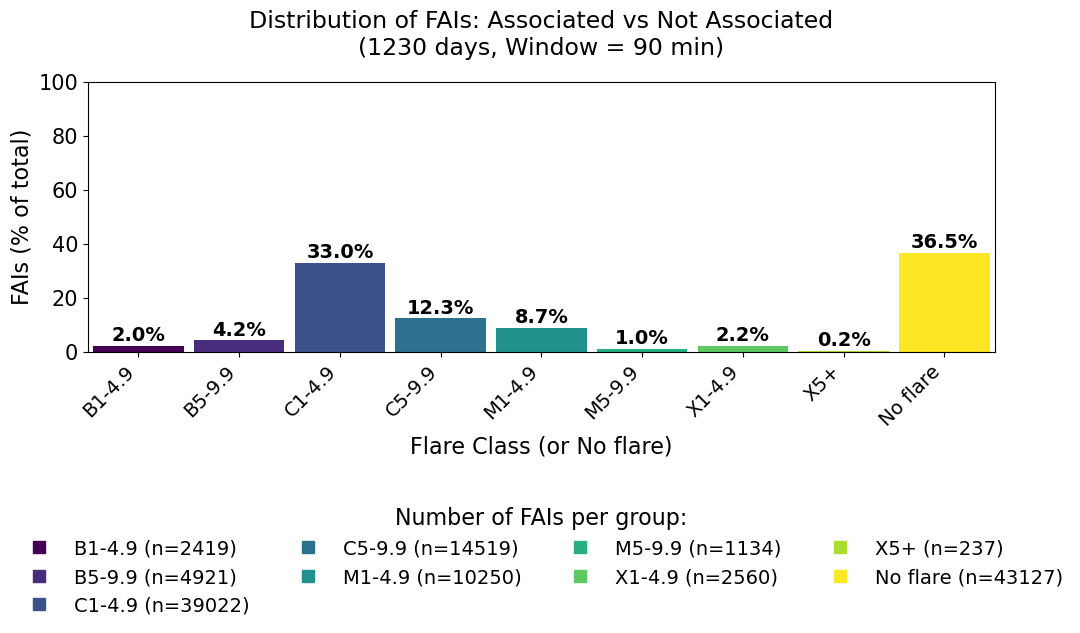

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window90min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 75062 (63.5%)
FAIs no asociados: 43127 (36.5%)

Distribución de FAIs asociados por clase:
  C1-4.9: 39022 FAIs (52.0%)
  C5-9.9: 14519 FAIs (19.3%)
  M1-4.9: 10250 FAIs (13.7%)
  B5-9.9: 4921 FAIs (6.6%)
  X1-4.9: 2560 FAIs (3.4%)
  B1-4.9: 2419 FAIs (3.2%)
  M5-9.9: 1134 FAIs (1.5%)
  X5+: 237 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_90min_subclassTrue.png

📊 Procesando: df_fai_assoc_95min.csv (ventana: 95 min)
   📋 Columnas disponibles: ['Unnamed: 0', 'date', 'observatory', 'xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'Time_FAI', 'Associated_Fla

/tmp/ipykernel_7303/3312764580.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


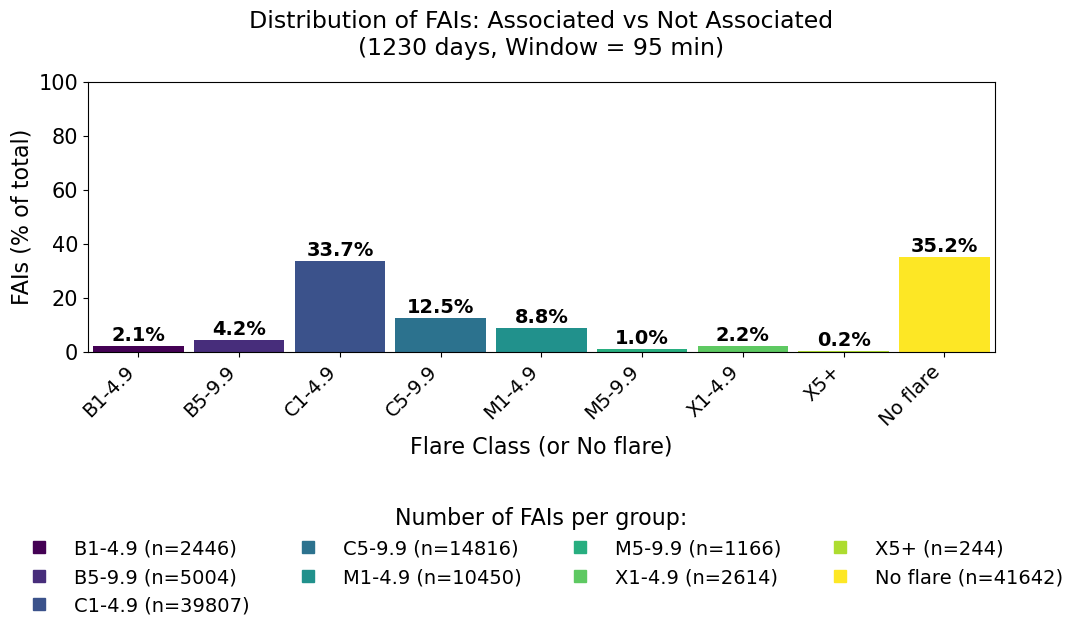

grafica extraña se guardo en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/1230d_Distribution_FAIs_All_Window95min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 118189
FAIs asociados a flares: 76547 (64.8%)
FAIs no asociados: 41642 (35.2%)

Distribución de FAIs asociados por clase:
  C1-4.9: 39807 FAIs (52.0%)
  C5-9.9: 14816 FAIs (19.4%)
  M1-4.9: 10450 FAIs (13.7%)
  B5-9.9: 5004 FAIs (6.5%)
  X1-4.9: 2614 FAIs (3.4%)
  B1-4.9: 2446 FAIs (3.2%)
  M5-9.9: 1166 FAIs (1.5%)
  X5+: 244 FAIs (0.3%)
   ✅ Gráfica correcta distribución guardada: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots/distribution_95min_subclassTrue.png

🎯 Todas las gráficas de distribución guardadas en: 2025-10-24_Analysis_for_1230_days/Analysis/WindowsFAI/graphics_from_existing/fai_distribution_plots


In [221]:
# Ejecutar para todas las ventanas
distribution_results = plot_fai_distribution_for_all_windows(
    base_dir=association_dir,
    n_days=n_days
)

## Función para gráficas comparativas entre ventanas

In [222]:
def plot_association_windows_comparison(df_summary, window_start, window_end, step, n_days):
    """
    Genera gráfica comparativa de los resultados de asociación por ventana de tiempo.
    """
    if len(df_summary) == 0:
        print("❌ No hay datos para generar gráfica comparativa")
        return
    
    # Configuración del estilo
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfica 1: Tasa de asociación
    bars1 = ax1.bar(df_summary['window_minutes'], df_summary['association_rate'], 
                   color='lightblue', edgecolor='navy', alpha=0.7, width=0.8)
    ax1.set_xlabel('Window Size (minutes)')
    ax1.set_ylabel('Association Rate (%)')
    ax1.set_title('FAI-Flare Association Rate\nby Window Size')
    ax1.set_xticks(df_summary['window_minutes'])
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, max(df_summary['association_rate']) * 1.15)
    
    # Añadir valores en las barras
    for bar, rate in zip(bars1, df_summary['association_rate']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Resaltar la mejor ventana
    best_idx = df_summary['association_rate'].idxmax()
    best_window = df_summary.loc[best_idx, 'window_minutes']
    best_rate = df_summary.loc[best_idx, 'association_rate']
    bars1[best_idx].set_color('lightgreen')
    bars1[best_idx].set_edgecolor('darkgreen')
    bars1[best_idx].set_alpha(0.9)
    
    # Gráfica 2: Conteos absolutos
    x = np.arange(len(df_summary))
    width = 0.35
    
    bars2_associated = ax2.bar(x - width/2, df_summary['associated_fais'], width, 
                              label='Associated FAIs', color='lightgreen', alpha=0.7)
    bars2_total = ax2.bar(x + width/2, df_summary['total_fais'], width, 
                         label='Total FAIs', color='lightcoral', alpha=0.7)
    
    ax2.set_xlabel('Window Size (minutes)')
    ax2.set_ylabel('Number of FAIs')
    ax2.set_title('FAI Counts by Window Size')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_summary['window_minutes'])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras de conteos
    for i, (assoc, total) in enumerate(zip(df_summary['associated_fais'], df_summary['total_fais'])):
        ax2.text(i - width/2, assoc + max(df_summary['total_fais']) * 0.01, 
                f'{assoc}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax2.text(i + width/2, total + max(df_summary['total_fais']) * 0.01, 
                f'{total}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'FAI-Flare Association Analysis: Windows {window_start}-{window_end} min (Step: {step} min)\n{n_days} days of data', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Guardar
    output_path = os.path.join(graphics_dir, f"association_windows_comparison_{window_start}to{window_end}_step{step}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    # Estadísticas
    print(f"\n📊 RESUMEN COMPARATIVO ASOCIACIÓN:")
    print(f"   🏆 Mejor ventana: {best_window} min ({best_rate:.1f}%)")
    print(f"   📈 Rango de tasas: {df_summary['association_rate'].min():.1f}% - {df_summary['association_rate'].max():.1f}%")
    print(f"   📋 Total de FAIs analizados: {df_summary['total_fais'].sum()}")
    print(f"   🔗 FAIs asociados totales: {df_summary['associated_fais'].sum()}")
    print(f"   💾 Gráfica guardada: {os.path.basename(output_path)}")

In [223]:
def plot_anticipation_windows_comparison(df_summary, window_start, window_end, step, n_days):
    """
    Genera gráfica comparativa de los resultados de anticipación por ventana de tiempo.
    """
    if len(df_summary) == 0:
        print("❌ No hay datos para generar gráfica comparativa")
        return
    
    # Configuración del estilo
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfica 1: Tasa de anticipación
    bars1 = ax1.bar(df_summary['window_minutes'], df_summary['anticipation_rate'], 
                   color='lightcoral', edgecolor='darkred', alpha=0.7, width=0.8)
    ax1.set_xlabel('Window Size (minutes)')
    ax1.set_ylabel('Anticipation Rate (%)')
    ax1.set_title('Flare Anticipation Rate\nby Window Size')
    ax1.set_xticks(df_summary['window_minutes'])
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, max(df_summary['anticipation_rate']) * 1.15)
    
    # Añadir valores en las barras
    for bar, rate in zip(bars1, df_summary['anticipation_rate']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Resaltar la mejor ventana
    best_idx = df_summary['anticipation_rate'].idxmax()
    best_window = df_summary.loc[best_idx, 'window_minutes']
    best_rate = df_summary.loc[best_idx, 'anticipation_rate']
    bars1[best_idx].set_color('orange')
    bars1[best_idx].set_edgecolor('darkorange')
    bars1[best_idx].set_alpha(0.9)
    
    # Gráfica 2: Conteos absolutos
    x = np.arange(len(df_summary))
    width = 0.35
    
    bars2_with_fai = ax2.bar(x - width/2, df_summary['flares_with_fai'], width, 
                            label='Flares with FAI', color='orange', alpha=0.7)
    bars2_total = ax2.bar(x + width/2, df_summary['total_flares'], width, 
                         label='Total Flares', color='lightblue', alpha=0.7)
    
    ax2.set_xlabel('Window Size (minutes)')
    ax2.set_ylabel('Number of Flares')
    ax2.set_title('Flare Counts by Window Size')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_summary['window_minutes'])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras de conteos
    for i, (with_fai, total) in enumerate(zip(df_summary['flares_with_fai'], df_summary['total_flares'])):
        ax2.text(i - width/2, with_fai + max(df_summary['total_flares']) * 0.01, 
                f'{with_fai}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax2.text(i + width/2, total + max(df_summary['total_flares']) * 0.01, 
                f'{total}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'Flare Anticipation Analysis: Windows {window_start}-{window_end} min (Step: {step} min)\n{n_days} days of data', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Guardar
    output_path = os.path.join(graphics_dir, f"anticipation_windows_comparison_{window_start}to{window_end}_step{step}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    # Estadísticas
    print(f"\n📊 RESUMEN COMPARATIVO ANTICIPACIÓN:")
    print(f"   🏆 Mejor ventana: {best_window} min ({best_rate:.1f}%)")
    print(f"   📈 Rango de tasas: {df_summary['anticipation_rate'].min():.1f}% - {df_summary['anticipation_rate'].max():.1f}%")
    print(f"   📋 Total de flares analizados: {df_summary['total_flares'].sum()}")
    print(f"   🔮 Flares con FAI totales: {df_summary['flares_with_fai'].sum()}")
    print(f"   💾 Gráfica guardada: {os.path.basename(output_path)}")

In [224]:
def plot_windows_comparison_from_summary(base_dir, analysis_type, n_days):
    """
    Genera gráficas comparativas a partir de los archivos de resumen.
    """
    summary_file = None
    
    if analysis_type == "association":
        pattern = os.path.join(base_dir, "*association_summary*.csv")
    elif analysis_type == "anticipation":
        pattern = os.path.join(base_dir, "*anticipation_summary*.csv")
    else:
        print("❌ Tipo de análisis no válido")
        return
    
    summary_files = glob.glob(pattern)
    
    if not summary_files:
        print(f"❌ No se encontró archivo de resumen en: {base_dir}")
        return
    
    summary_file = summary_files[0]
    print(f"📊 Leyendo resumen: {os.path.basename(summary_file)}")
    
    try:
        df_summary = pd.read_csv(summary_file)
        
        # Extraer información de ventanas del nombre del archivo - VERSIÓN CORREGIDA
        filename = os.path.basename(summary_file).replace('.csv', '')
        print(f"📝 Procesando archivo: {filename}")
        
        # Buscar patrones específicos en el nombre
        import re
        
        # Patrón 1: buscar "30to60_step5" 
        pattern1 = r'(\d+)to(\d+)_step(\d+)'
        match1 = re.search(pattern1, filename)
        
        if match1:
            window_start = int(match1.group(1))
            window_end = int(match1.group(2))
            step = int(match1.group(3))
            print(f"✅ Parámetros extraídos: {window_start}to{window_end}_step{step}")
        else:
            # Patrón 2: buscar números separados por caracteres
            pattern2 = r'(\d+).*?(\d+).*?(\d+)'
            match2 = re.search(pattern2, filename)
            if match2:
                window_start = int(match2.group(1))
                window_end = int(match2.group(2))
                step = int(match2.group(3))
                print(f"✅ Parámetros extraídos (patrón 2): {window_start}to{window_end}_step{step}")
            else:
                # Si no podemos extraer, usar valores por defecto basados en los datos
                print("⚠️ No se pudieron extraer parámetros del nombre, usando valores por defecto")
                window_start = df_summary['window_minutes'].min()
                window_end = df_summary['window_minutes'].max()
                step = 5  # Valor por defecto
                print(f"✅ Parámetros inferidos: {window_start}to{window_end}_step{step}")
        
        if analysis_type == "association":
            plot_association_windows_comparison(df_summary, window_start, window_end, step, n_days)
            print("📈 Gráfica comparativa de asociación generada")
        else:
            plot_anticipation_windows_comparison(df_summary, window_start, window_end, step, n_days)
            print("📈 Gráfica comparativa de anticipación generada")
            
    except Exception as e:
        print(f"❌ Error generando gráfica comparativa: {e}")
        import traceback
        traceback.print_exc()
    """
    Genera gráficas comparativas a partir de los archivos de resumen.
    """
    summary_file = None
    
    if analysis_type == "association":
        pattern = os.path.join(base_dir, "*association_summary*.csv")
    elif analysis_type == "anticipation":
        pattern = os.path.join(base_dir, "*anticipation_summary*.csv")
    else:
        print("❌ Tipo de análisis no válido")
        return
    
    summary_files = glob.glob(pattern)
    
    if not summary_files:
        print(f"❌ No se encontró archivo de resumen en: {base_dir}")
        return
    
    summary_file = summary_files[0]
    print(f"📊 Leyendo resumen: {os.path.basename(summary_file)}")
    
    try:
        df_summary = pd.read_csv(summary_file)
        
        # Extraer información de ventanas del nombre del archivo
        filename = os.path.basename(summary_file)
        parts = filename.replace('.csv', '').split('_')
        window_start = int(parts[-3].replace('to', '').replace('step', ''))
        window_end = int(parts[-2])
        step = int(parts[-1])
        
        if analysis_type == "association":
            plot_association_windows_comparison(df_summary, window_start, window_end, step, n_days)
            print("📈 Gráfica comparativa de asociación generada")
        else:
            plot_anticipation_windows_comparison(df_summary, window_start, window_end, step, n_days)
            print("📈 Gráfica comparativa de anticipación generada")
            
    except Exception as e:
        print(f"❌ Error generando gráfica comparativa: {e}")

📊 Leyendo resumen: association_summary_65to120_step5.csv
📝 Procesando archivo: association_summary_65to120_step5
✅ Parámetros extraídos: 65to120_step5


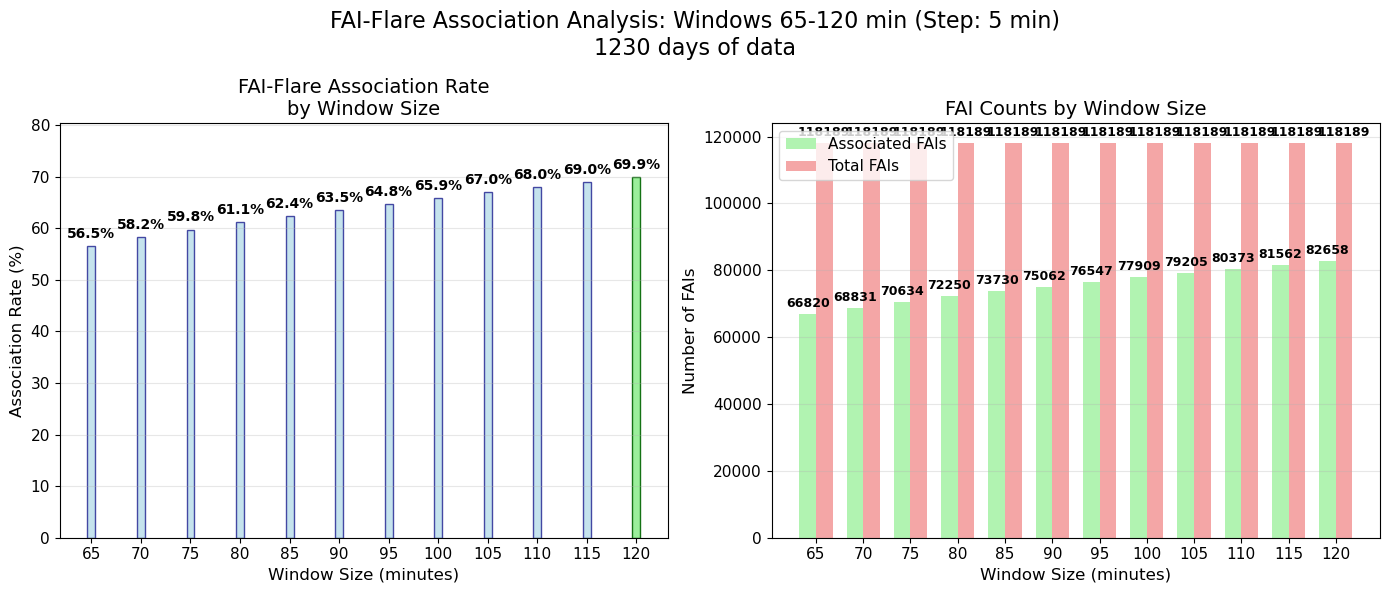


📊 RESUMEN COMPARATIVO ASOCIACIÓN:
   🏆 Mejor ventana: 120 min (69.9%)
   📈 Rango de tasas: 56.5% - 69.9%
   📋 Total de FAIs analizados: 1418268
   🔗 FAIs asociados totales: 905581
   💾 Gráfica guardada: association_windows_comparison_65to120_step5.png
📈 Gráfica comparativa de asociación generada
📊 Leyendo resumen: association_summary_65to120_step5.csv
❌ Error generando gráfica comparativa: invalid literal for int() with base 10: 'summary'


In [225]:
# Solo gráficas comparativas
plot_windows_comparison_from_summary(association_dir, "association", n_days)


📊 Leyendo resumen: anticipation_summary_65to120_step5.csv
📝 Procesando archivo: anticipation_summary_65to120_step5
✅ Parámetros extraídos: 65to120_step5


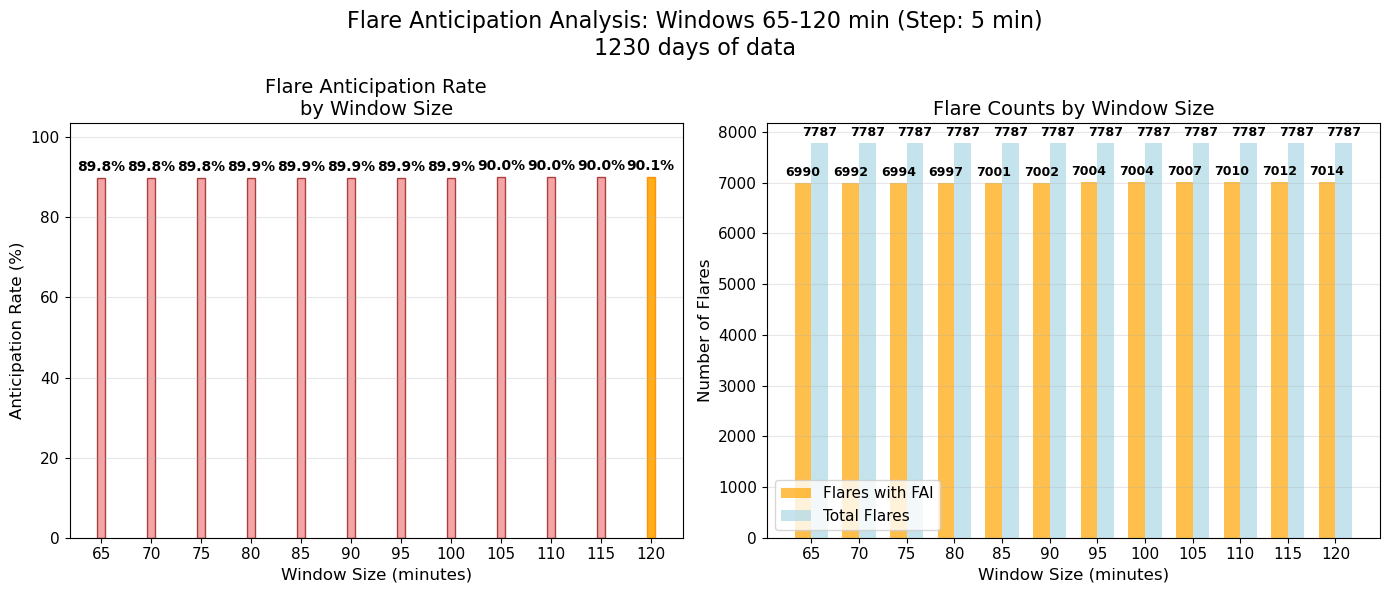


📊 RESUMEN COMPARATIVO ANTICIPACIÓN:
   🏆 Mejor ventana: 120 min (90.1%)
   📈 Rango de tasas: 89.8% - 90.1%
   📋 Total de flares analizados: 93444
   🔮 Flares con FAI totales: 84027
   💾 Gráfica guardada: anticipation_windows_comparison_65to120_step5.png
📈 Gráfica comparativa de anticipación generada
📊 Leyendo resumen: anticipation_summary_65to120_step5.csv
❌ Error generando gráfica comparativa: invalid literal for int() with base 10: 'summary'


In [226]:
plot_windows_comparison_from_summary(anticipation_dir, "anticipation", n_days)

## Renombrar con 3 cifras las imágenes

In [227]:
import os
import re

carpeta_destino1 = os.path.join(graphics_dir, "association_plots")
carpeta_destino2 = os.path.join(graphics_dir, "fai_distribution_plots")
carpeta_destino3 = os.path.join(graphics_dir, "Flares_asociatad_fai_plots")


def renombrar_archivos_en_carpeta(carpeta=carpeta_destino1):
    
    
    if not os.path.exists(carpeta):
        print(f"La carpeta no existe: {carpeta}")
        return
    
    for filename in os.listdir(carpeta):
        if not filename.endswith('.png'):
            continue
            
        # Buscar cualquier patrón que tenga _número_min
        # Esto cubre: _30min.png, _30min_subclassTrue.png, etc.
        match = re.search(r'_(\d{1,2})min', filename)
        if match:
            number = int(match.group(1))
            
            if number < 100:
                new_number = f"{number:03d}"
                new_filename = filename.replace(f"_{number}min", f"_{new_number}min")
                
                old_path = os.path.join(carpeta, filename)
                new_path = os.path.join(carpeta, new_filename)
                
                if not os.path.exists(new_path):
                    os.rename(old_path, new_path)
                    print(f"Renombrado: {filename} -> {new_filename}")
                else:
                    print(f"El archivo ya existe: {new_filename}")



In [228]:

# Ejecutar
if __name__ == "__main__":
    renombrar_archivos_en_carpeta(carpeta=carpeta_destino1)
    renombrar_archivos_en_carpeta(carpeta=carpeta_destino2)
    renombrar_archivos_en_carpeta(carpeta=carpeta_destino3)


Renombrado: association_summary_65min.png -> association_summary_065min.png
Renombrado: fai_to_peak_times_65min.png -> fai_to_peak_times_065min.png
Renombrado: fai_times_by_class_65min.png -> fai_times_by_class_065min.png
Renombrado: association_summary_70min.png -> association_summary_070min.png
Renombrado: fai_to_peak_times_70min.png -> fai_to_peak_times_070min.png
Renombrado: fai_times_by_class_70min.png -> fai_times_by_class_070min.png
Renombrado: association_summary_75min.png -> association_summary_075min.png
Renombrado: fai_to_peak_times_75min.png -> fai_to_peak_times_075min.png
Renombrado: fai_times_by_class_75min.png -> fai_times_by_class_075min.png
Renombrado: association_summary_80min.png -> association_summary_080min.png
Renombrado: fai_to_peak_times_80min.png -> fai_to_peak_times_080min.png
Renombrado: fai_times_by_class_80min.png -> fai_times_by_class_080min.png
Renombrado: association_summary_85min.png -> association_summary_085min.png
Renombrado: fai_to_peak_times_85min.